# P-153- Hourly Energy Consumption Forecast 

Business Objective:
PJM Hourly Energy Consumption Data
PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

The regions have changed over the years so data may only appear for certain dates per region.

•	Split the last year into a test set- can you build a model to predict energy consumption?
•	Find trends in energy consumption around hours of the day, holidays, or long term trends?
•	Understand how daily trends change depending of the time of year. Summer trends are very different than winter trends.
•	Forecast for next 30 days.


#### Import the libraries

In [143]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import itertools
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
import statsmodels.graphics.tsaplots as tsa_plots
from pmdarima.utils import c, diff

#### Read the dataset and do the EDA

In [144]:
df= pd.read_csv("PJMW_hourly.csv", header=0, index_col=0, parse_dates=True)

In [145]:
df.shape

(143206, 1)

In [146]:
df.head()

,PJMW_MW
Datetime,
2002-12-31 01:00:00,5077.0
2002-12-31 02:00:00,4939.0
2002-12-31 03:00:00,4885.0
2002-12-31 04:00:00,4857.0
2002-12-31 05:00:00,4930.0


In [147]:
df.tail()

,PJMW_MW
Datetime,
2018-01-01 20:00:00,8401.0
2018-01-01 21:00:00,8373.0
2018-01-01 22:00:00,8238.0
2018-01-01 23:00:00,7958.0
2018-01-02 00:00:00,7691.0


In [148]:
df.shape

(143206, 1)

In [149]:
df.dtypes

PJMW_MW    float64
dtype: object

In [150]:
df.describe()

,PJMW_MW
count,143206.000000
mean,5602.375089
std,979.142872
min,487.000000
25%,4907.000000
50%,5530.000000
75%,6252.000000
max,9594.000000


We have the hourly energy consumption data with 143206 rows from 2002 to 2018. 

In [151]:
df = df.sort_index()

Sorted the dataset to arrange it in ascending order

In [152]:
df.head()

,PJMW_MW
Datetime,
2002-04-01 01:00:00,4374.0
2002-04-01 02:00:00,4306.0
2002-04-01 03:00:00,4322.0
2002-04-01 04:00:00,4359.0
2002-04-01 05:00:00,4436.0


In [153]:
df.tail()

,PJMW_MW
Datetime,
2018-08-02 20:00:00,6545.0
2018-08-02 21:00:00,6496.0
2018-08-02 22:00:00,6325.0
2018-08-02 23:00:00,5892.0
2018-08-03 00:00:00,5489.0


After sorting we found out that the data is from April 2002 to August 2018

In [154]:
df[df.index.duplicated()]

,PJMW_MW
Datetime,
2014-11-02 02:00:00,4613.0
2015-11-01 02:00:00,3832.0
2016-11-06 02:00:00,4089.0
2017-11-05 02:00:00,4042.0


In [155]:
unique, counts = np.unique(df.index.duplicated(), return_counts=True)

In [156]:
dict(zip(unique, counts))

{False: 143202, True: 4}

There are 4 Hours in the index that are duplicated in the data set

In [157]:
df['2014-11-02'].head()

C:\Users\ankit\AppData\Local\Temp\ipykernel_12100\3461424034.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df['2014-11-02'].head()


,PJMW_MW
Datetime,
2014-11-02 00:00:00,4912.0
2014-11-02 01:00:00,4805.0
2014-11-02 02:00:00,4571.0
2014-11-02 02:00:00,4613.0
2014-11-02 03:00:00,4619.0


In [158]:
df=df.groupby(level=0).mean()

In [159]:
df['2014-11-02'].head()

C:\Users\ankit\AppData\Local\Temp\ipykernel_12100\3461424034.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df['2014-11-02'].head()


,PJMW_MW
Datetime,
2014-11-02 00:00:00,4912.0
2014-11-02 01:00:00,4805.0
2014-11-02 02:00:00,4592.0
2014-11-02 03:00:00,4619.0
2014-11-02 04:00:00,4615.0


Replaced the duplicated indexes with the mean energy consumption values 

In [160]:
pd.date_range(df.index.min(), df.index.max(), freq="y").difference(df.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [161]:
pd.date_range(df.index.min(), df.index.max(), freq="m").difference(df.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [162]:
pd.date_range(df.index.min(), df.index.max(), freq="d").difference(df.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [163]:
pd.date_range(df.index.min(), df.index.max(), freq="H").difference(df.index)

DatetimeIndex(['2002-04-07 03:00:00', '2002-10-27 02:00:00',
               '2003-04-06 03:00:00', '2003-10-26 02:00:00',
               '2004-04-04 03:00:00', '2004-10-31 02:00:00',
               '2005-04-03 03:00:00', '2005-10-30 02:00:00',
               '2006-04-02 03:00:00', '2006-10-29 02:00:00',
               '2007-03-11 03:00:00', '2007-11-04 02:00:00',
               '2008-03-09 03:00:00', '2008-11-02 02:00:00',
               '2009-03-08 03:00:00', '2009-11-01 02:00:00',
               '2010-03-14 03:00:00', '2010-11-07 02:00:00',
               '2010-12-10 00:00:00', '2011-03-13 03:00:00',
               '2011-11-06 02:00:00', '2012-03-11 03:00:00',
               '2012-11-04 02:00:00', '2013-03-10 03:00:00',
               '2013-11-03 02:00:00', '2014-03-09 03:00:00',
               '2015-03-08 03:00:00', '2016-03-13 03:00:00',
               '2017-03-12 03:00:00', '2018-03-11 03:00:00'],
              dtype='datetime64[ns]', freq=None)

There are no missing years or date but there are 30 missing hours for the dataset. So we have deal with it.

In [164]:
df['2002-04-07'].head()

C:\Users\ankit\AppData\Local\Temp\ipykernel_12100\3585960419.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df['2002-04-07'].head()


,PJMW_MW
Datetime,
2002-04-07 00:00:00,5116.0
2002-04-07 01:00:00,5002.0
2002-04-07 02:00:00,4858.0
2002-04-07 04:00:00,4871.0
2002-04-07 05:00:00,4909.0


In [165]:
new_date_range = pd.date_range(df.index.min(), df.index.max(), freq="H")
df=df.reindex(new_date_range)
df.head(150)

,PJMW_MW
2002-04-01 01:00:00,4374.0
2002-04-01 02:00:00,4306.0
2002-04-01 03:00:00,4322.0
2002-04-01 04:00:00,4359.0
2002-04-01 05:00:00,4436.0
...,...
2002-04-07 02:00:00,4858.0
2002-04-07 03:00:00,NaN
2002-04-07 04:00:00,4871.0
2002-04-07 05:00:00,4909.0


In [166]:
df['PJMW_MW']=df.PJMW_MW.interpolate(method='linear')
df.head(150)

,PJMW_MW
2002-04-01 01:00:00,4374.0
2002-04-01 02:00:00,4306.0
2002-04-01 03:00:00,4322.0
2002-04-01 04:00:00,4359.0
2002-04-01 05:00:00,4436.0
...,...
2002-04-07 02:00:00,4858.0
2002-04-07 03:00:00,4864.5
2002-04-07 04:00:00,4871.0
2002-04-07 05:00:00,4909.0


The missing hours are added and imputed with the mean of the above and below power consumption values

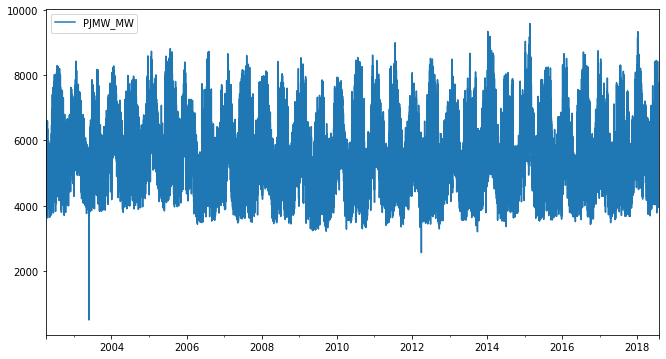

In [167]:
df.plot()
plt.show()

Though there is variation in the data ie, there is peak point as well as low points, there is no any specific trend. It looks like a stationary series with constatnt mean and sd.

array([[<AxesSubplot:title={'center':'PJMW_MW'}>]], dtype=object)

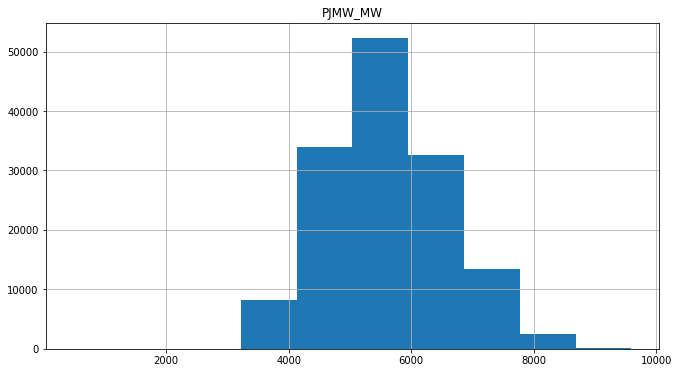

In [168]:
df.hist()

##### Plot the maximum,minimum and mean values of each year

<AxesSubplot:>

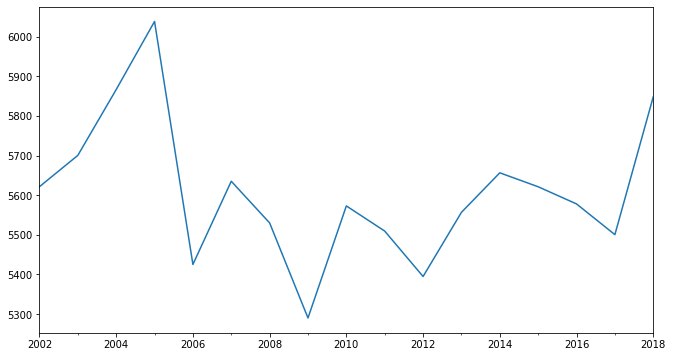

In [169]:
df.PJMW_MW.resample(rule='A').mean().plot()

<AxesSubplot:>

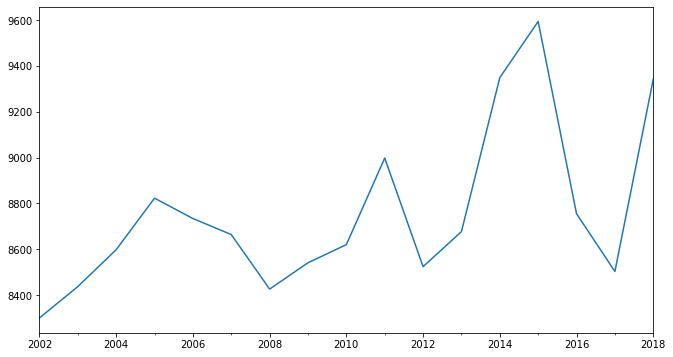

In [170]:
df.PJMW_MW.resample(rule='A').max().plot()

<AxesSubplot:>

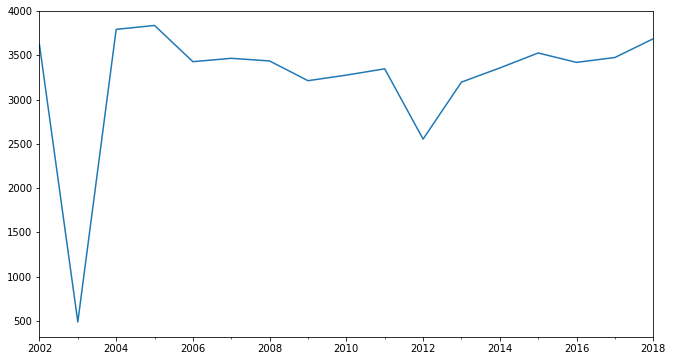

In [171]:
df.PJMW_MW.resample(rule='A').min().plot()

The minimum of 2003 seems to be an outlier.

In [172]:
df['2003'].PJMW_MW.resample(rule='A').min()

C:\Users\ankit\AppData\Local\Temp\ipykernel_12100\1706536110.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df['2003'].PJMW_MW.resample(rule='A').min()


2003-12-31    487.0
Freq: A-DEC, Name: PJMW_MW, dtype: float64

In [173]:
df[df['PJMW_MW']==487.0]

,PJMW_MW
2003-05-29,487.0


In [174]:
df['2003-05-29'].head()

C:\Users\ankit\AppData\Local\Temp\ipykernel_12100\3440883274.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df['2003-05-29'].head()


,PJMW_MW
2003-05-29 00:00:00,487.0
2003-05-29 01:00:00,4560.0
2003-05-29 02:00:00,4424.0
2003-05-29 03:00:00,4351.0
2003-05-29 04:00:00,4337.0


In [175]:
df['PJMW_MW'].mask(df['PJMW_MW']<500,inplace=True)

In [176]:
df['PJMW_MW']=df.PJMW_MW.interpolate(method='linear')


Replaced the outlier value with the linear interpolation method

In [177]:
df['2003-05-29'].head()

C:\Users\ankit\AppData\Local\Temp\ipykernel_12100\3440883274.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df['2003-05-29'].head()


,PJMW_MW
2003-05-29 00:00:00,4938.5
2003-05-29 01:00:00,4560.0
2003-05-29 02:00:00,4424.0
2003-05-29 03:00:00,4351.0
2003-05-29 04:00:00,4337.0


<AxesSubplot:>

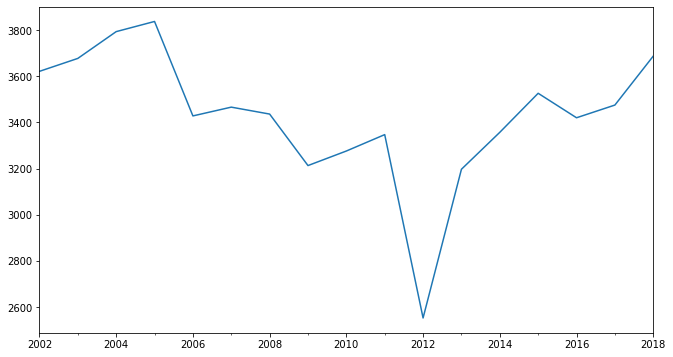

In [178]:
df.PJMW_MW.resample(rule='A').min().plot()

In [179]:
df[df['PJMW_MW']==2553.0]

,PJMW_MW
2012-04-02,2553.0


In [180]:
df['2012-04-02'].head()

C:\Users\ankit\AppData\Local\Temp\ipykernel_12100\3155559107.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df['2012-04-02'].head()


,PJMW_MW
2012-04-02 00:00:00,2553.0
2012-04-02 01:00:00,3904.0
2012-04-02 02:00:00,3779.0
2012-04-02 03:00:00,3776.0
2012-04-02 04:00:00,3764.0


In [181]:
df.to_csv('dataset.csv')

In [182]:
type(df)

pandas.core.frame.DataFrame

In [183]:
df1=df.copy()

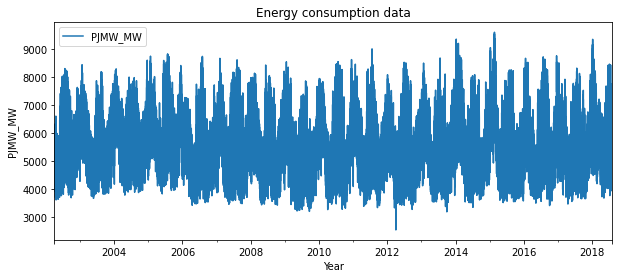

In [184]:
plt.rcParams["figure.figsize"]= (10,4)
df1.plot()
plt.xlabel('Year') 
plt.ylabel('PJMW_MW') 
# displaying the title
plt.title("Energy consumption data")
plt.show()

In [185]:
df1

,PJMW_MW
2002-04-01 01:00:00,4374.0
2002-04-01 02:00:00,4306.0
2002-04-01 03:00:00,4322.0
2002-04-01 04:00:00,4359.0
2002-04-01 05:00:00,4436.0
...,...
2018-08-02 20:00:00,6545.0
2018-08-02 21:00:00,6496.0
2018-08-02 22:00:00,6325.0
2018-08-02 23:00:00,5892.0


#### Extract the date,month,year, hour and weekname columns for further visualization

In [186]:
df1["Date"] = pd.to_datetime(df1.index,format='%Y-%m-%d %H:%M')

# Extracting Day, month name, year from the Datetime column using Date functions from pandas 

df1["month"] = df1.Date.dt.strftime("%b") # month extraction
df1["year"] = df1.Date.dt.strftime("%Y") # year extraction
df1["day"] = df1.Date.dt.strftime("%d") # day extraction
df1["Hour"] = df1.Date.dt.strftime("%H") # Hour extraction


In [187]:
df1

,PJMW_MW,Date,month,year,day,Hour
2002-04-01 01:00:00,4374.0,2002-04-01 01:00:00,Apr,2002,01,01
2002-04-01 02:00:00,4306.0,2002-04-01 02:00:00,Apr,2002,01,02
2002-04-01 03:00:00,4322.0,2002-04-01 03:00:00,Apr,2002,01,03
2002-04-01 04:00:00,4359.0,2002-04-01 04:00:00,Apr,2002,01,04
2002-04-01 05:00:00,4436.0,2002-04-01 05:00:00,Apr,2002,01,05
...,...,...,...,...,...,...
2018-08-02 20:00:00,6545.0,2018-08-02 20:00:00,Aug,2018,02,20
2018-08-02 21:00:00,6496.0,2018-08-02 21:00:00,Aug,2018,02,21
2018-08-02 22:00:00,6325.0,2018-08-02 22:00:00,Aug,2018,02,22
2018-08-02 23:00:00,5892.0,2018-08-02 23:00:00,Aug,2018,02,23


In [188]:
df1.drop('Date',axis=1,inplace=True)

In [189]:
# df1 = df1.reset_index()

# df1['weekday'] = df1['Datetime'].dt.dayofweek

# df1['weekday'] = pd.to_datetime(df1.index).day_of_week
df1['weekday_name'] = pd.to_datetime(df1.index).day_name()


In [190]:
df1

,PJMW_MW,month,year,day,Hour,weekday_name
2002-04-01 01:00:00,4374.0,Apr,2002,01,01,Monday
2002-04-01 02:00:00,4306.0,Apr,2002,01,02,Monday
2002-04-01 03:00:00,4322.0,Apr,2002,01,03,Monday
2002-04-01 04:00:00,4359.0,Apr,2002,01,04,Monday
2002-04-01 05:00:00,4436.0,Apr,2002,01,05,Monday
...,...,...,...,...,...,...
2018-08-02 20:00:00,6545.0,Aug,2018,02,20,Thursday
2018-08-02 21:00:00,6496.0,Aug,2018,02,21,Thursday
2018-08-02 22:00:00,6325.0,Aug,2018,02,22,Thursday
2018-08-02 23:00:00,5892.0,Aug,2018,02,23,Thursday


In [191]:
df2=df1.copy()

In [192]:
df2.index.name= 'Datetime'

In [193]:
df2

,PJMW_MW,month,year,day,Hour,weekday_name
Datetime,,,,,,
2002-04-01 01:00:00,4374.0,Apr,2002,01,01,Monday
2002-04-01 02:00:00,4306.0,Apr,2002,01,02,Monday
2002-04-01 03:00:00,4322.0,Apr,2002,01,03,Monday
2002-04-01 04:00:00,4359.0,Apr,2002,01,04,Monday
2002-04-01 05:00:00,4436.0,Apr,2002,01,05,Monday
...,...,...,...,...,...,...
2018-08-02 20:00:00,6545.0,Aug,2018,02,20,Thursday
2018-08-02 21:00:00,6496.0,Aug,2018,02,21,Thursday
2018-08-02 22:00:00,6325.0,Aug,2018,02,22,Thursday


<AxesSubplot:>

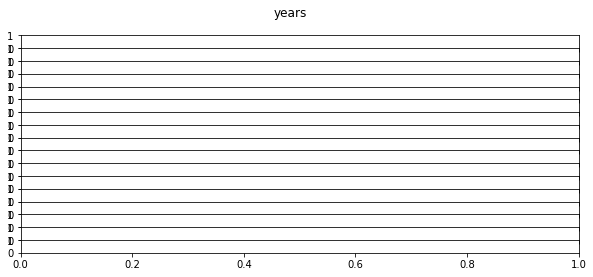

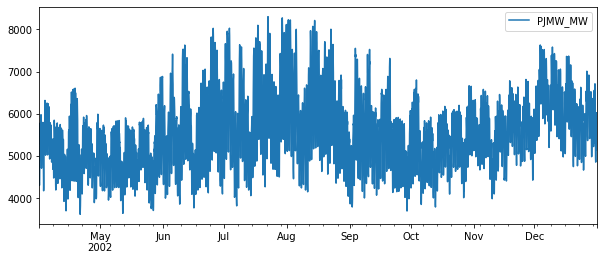

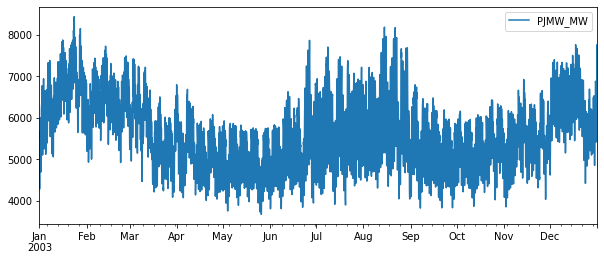

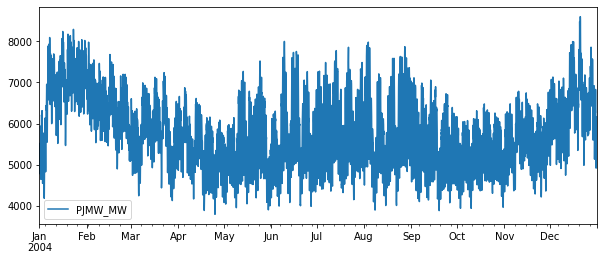

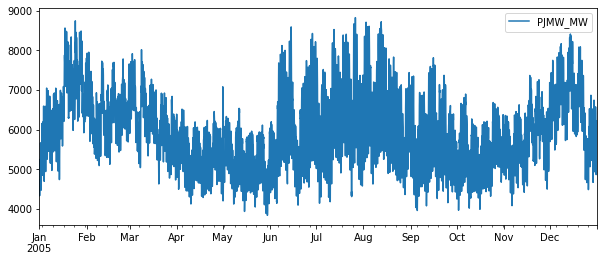

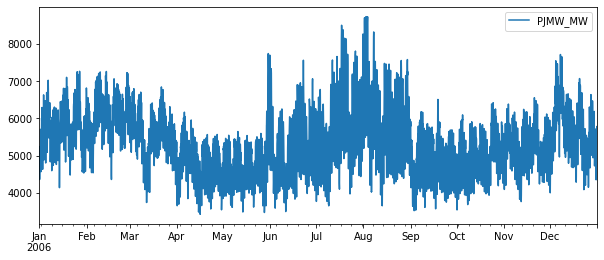

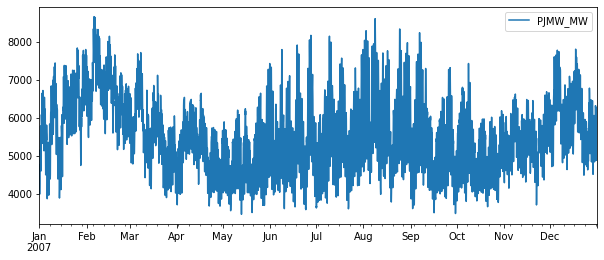

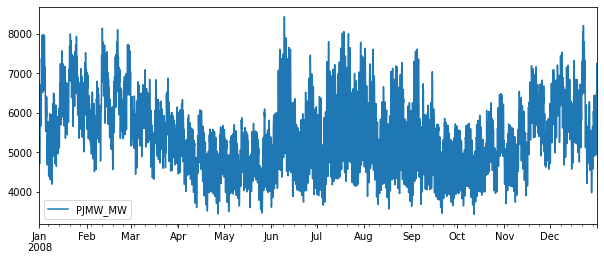

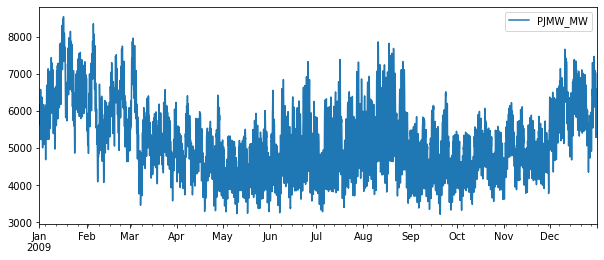

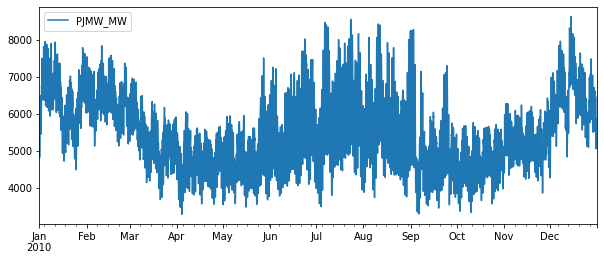

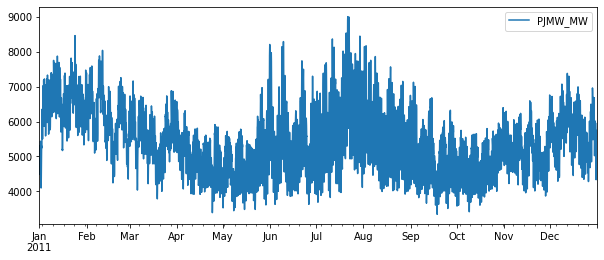

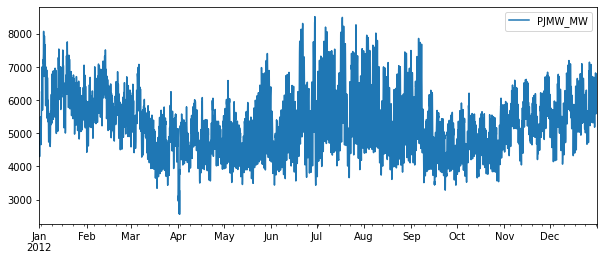

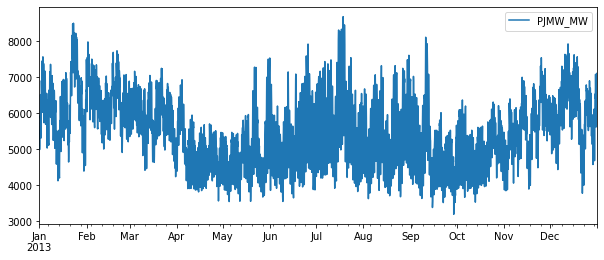

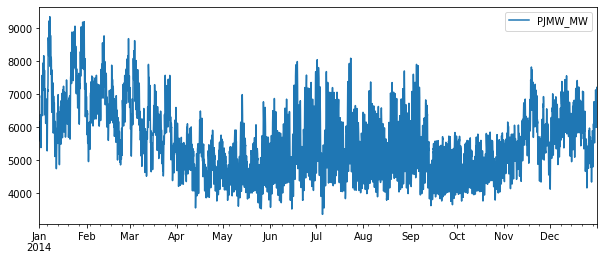

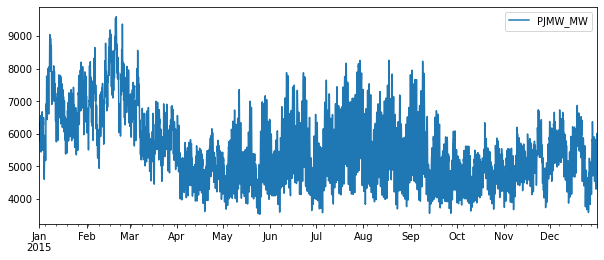

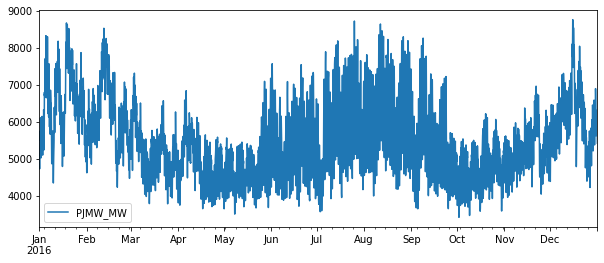

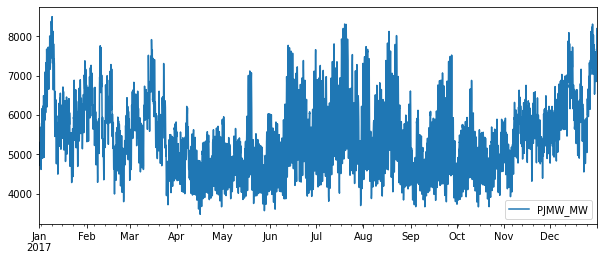

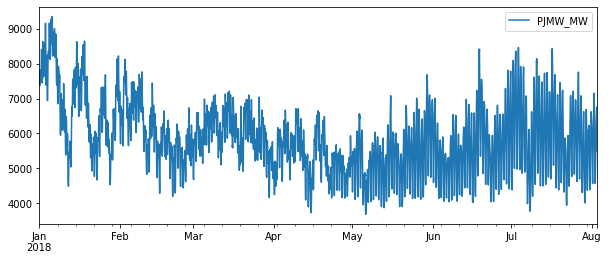

In [194]:
fig = plt.figure()
gs = fig.add_gridspec(17, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
fig.suptitle('years')
df.loc['2002'].plot()
df.loc['2003'].plot()
df.loc['2004'].plot()
df.loc['2005'].plot()
df.loc['2006'].plot()
df.loc['2007'].plot()
df.loc['2008'].plot()
df.loc['2009'].plot()
df.loc['2010'].plot()
df.loc['2011'].plot()
df.loc['2012'].plot()
df.loc['2013'].plot()
df.loc['2014'].plot()
df.loc['2015'].plot()
df.loc['2016'].plot()
df.loc['2017'].plot()
df.loc['2018'].plot()


In [195]:
df2.describe()

,PJMW_MW
count,143232.000000
mean,5602.245472
std,979.086063
min,2553.000000
25%,4906.000000
50%,5530.000000
75%,6252.000000
max,9594.000000


#### Check for the yearly trend

Text(0.5, 1.0, 'Yearly trend')

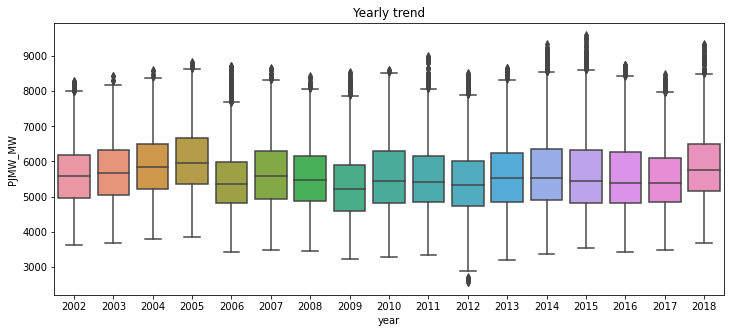

In [196]:
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(x = df2.year,
                y = df2['PJMW_MW'], 
                ax = ax)
ax.set_title('Yearly trend')

Observation: Low consumption in 2009 and high consumption in 2005

#### Check for the monthly trend

Text(0.5, 1.0, 'Monthly trend')

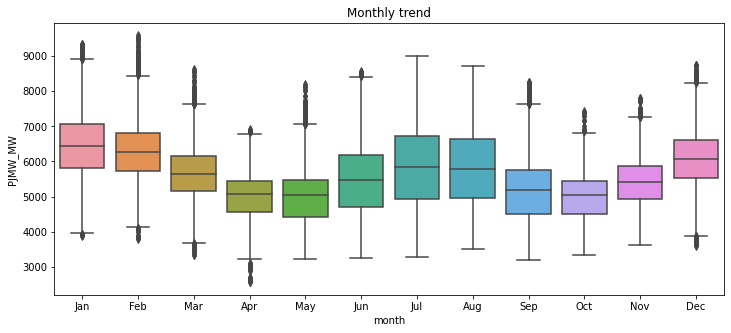

In [197]:
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(x = df2.month,
                y = df2['PJMW_MW'], order=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
                ax = ax)
ax.set_title('Monthly trend')

In [198]:
df3=df2.copy()

Observation: For Dec, Jan, Feb and Jun,Jul, Aug the consumptin is higher as compared to other months.

#### Create the column 'Season' to Check for the seasonal trend

In [199]:
df3['season']=df3['month'].copy()

In [200]:
df3['season']=df3['season'].map({'Jan':'Winter','Feb':'Winter','Mar':'Winter','Apr':'Spring','May':'Spring','Jun':'Spring','Aug':'Summer','Sep':'Summer','Jul':'Summer','Oct': 'Fall','Nov': 'Fall','Dec': 'Fall'})


In [201]:
df3.head()

,PJMW_MW,month,year,day,Hour,weekday_name,season
Datetime,,,,,,,
2002-04-01 01:00:00,4374.0,Apr,2002,01,01,Monday,Spring
2002-04-01 02:00:00,4306.0,Apr,2002,01,02,Monday,Spring
2002-04-01 03:00:00,4322.0,Apr,2002,01,03,Monday,Spring
2002-04-01 04:00:00,4359.0,Apr,2002,01,04,Monday,Spring
2002-04-01 05:00:00,4436.0,Apr,2002,01,05,Monday,Spring


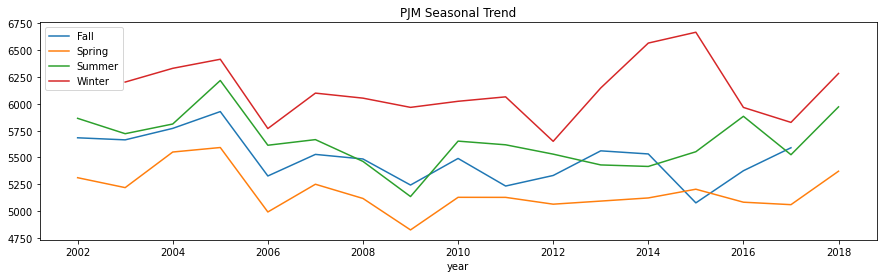

In [202]:
df3.pivot_table(index=df3['year'], 
                     columns='season', 
                     values='PJMW_MW',
                     aggfunc='mean').plot(figsize=(15,4),
                     title='PJM Seasonal Trend')
plt.legend(loc='upper left')

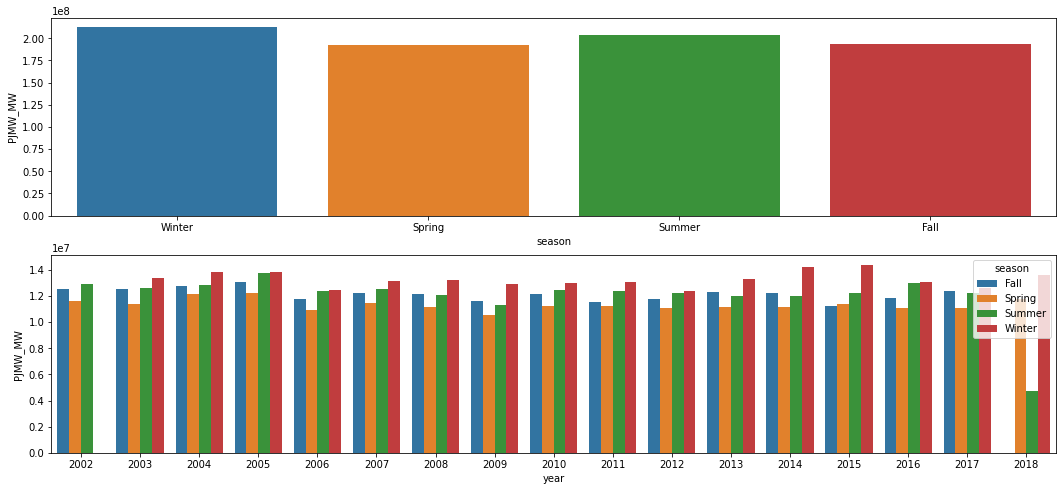

In [203]:
plt.figure(figsize=(18,8))
aux1 = df3[['season', 'PJMW_MW']].groupby( 'season' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='season', y='PJMW_MW', data=aux1, order=['Winter', 'Spring', 'Summer', 'Fall'] )

aux2 = df3[['year', 'season', 'PJMW_MW']].groupby( ['year', 'season'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='year', y='PJMW_MW', hue='season', data=aux2 );

Observation: For winter season the energy consumption is on a higher side and for spring the consumption is comparatively low

<AxesSubplot:xlabel='month', ylabel='year'>

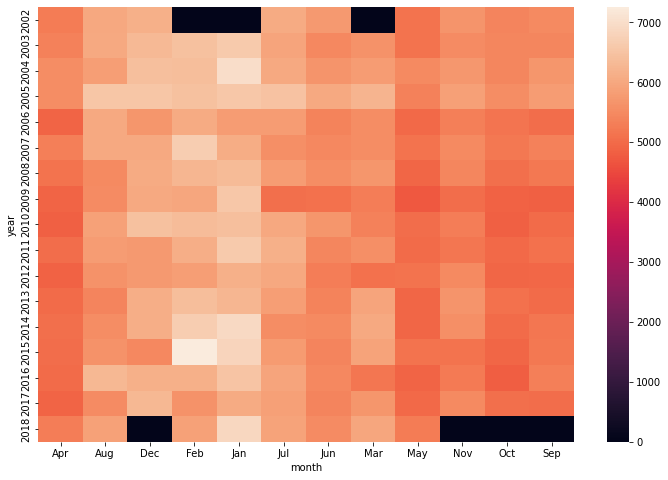

In [204]:

plt.figure(figsize=(12,8))
heatmap = pd.pivot_table(data=df2,values="PJMW_MW",index="year",columns="month",aggfunc="median",fill_value=0)
sns.heatmap(heatmap ,fmt="g")

#### Check for the hourly trend

Text(0.5, 1.0, 'Daily trend - Hourly basis')

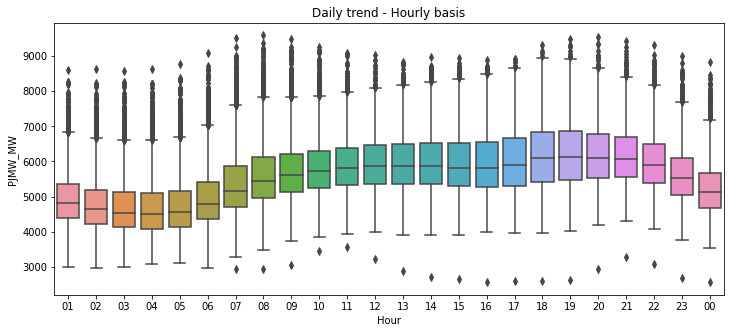

In [205]:
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(x = df2.Hour,
                y = df2['PJMW_MW'], 
                ax = ax)
ax.set_title('Daily trend - Hourly basis')

Observation: From midnight after 10 pm the power consumption starts decreasing and from morning 7 it increases till 10 pm.

#### Check for the daily trend

<AxesSubplot:xlabel='day', ylabel='PJMW_MW'>

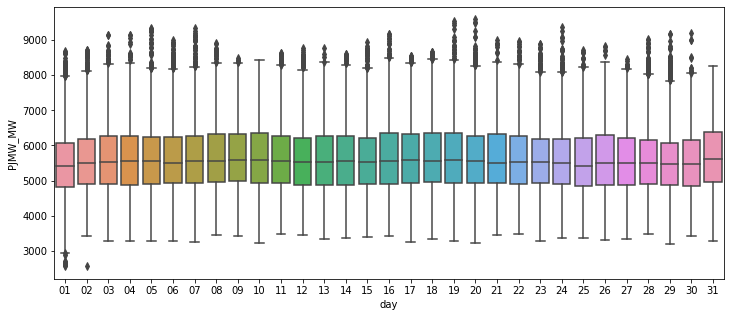

In [206]:
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(x = df2.day,
                y = df2['PJMW_MW'],
                ax = ax)

#### Check for the Weekly trend

<AxesSubplot:xlabel='weekday_name', ylabel='PJMW_MW'>

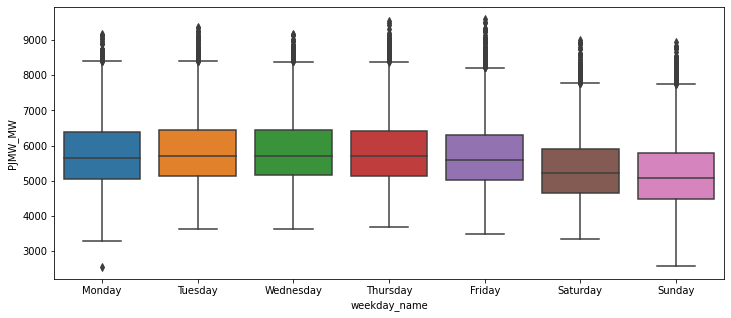

In [207]:
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(x = df2.weekday_name,
                y = df2['PJMW_MW'],order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
                ax = ax)

Observation:Low power consumption during Weekends

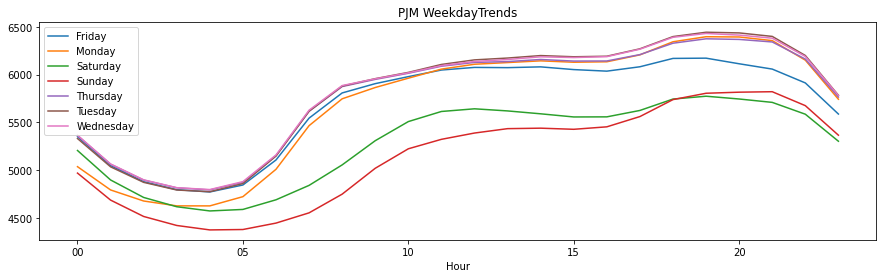

In [208]:
df2.pivot_table(index=df2['Hour'], 
                     columns='weekday_name', 
                     values='PJMW_MW',
                     aggfunc='mean').plot(figsize=(15,4),
                     title='PJM WeekdayTrends')
plt.legend(loc='upper left')

Observation: The plot shows that there are less consumption of power during weekends as compared to weekdays. Also the power consumption began to rise from morning 7 and at midnight 10 it again decreases.

In [209]:
df3['date'] = df3.index.date

In [210]:
df4=df3.reset_index()


#### Check for the Holiday trend

In [211]:
import holidays
df4['holidays'] = df4.date.apply( lambda x: 'Holiday' if x in holidays.US() else 'Normal day' )


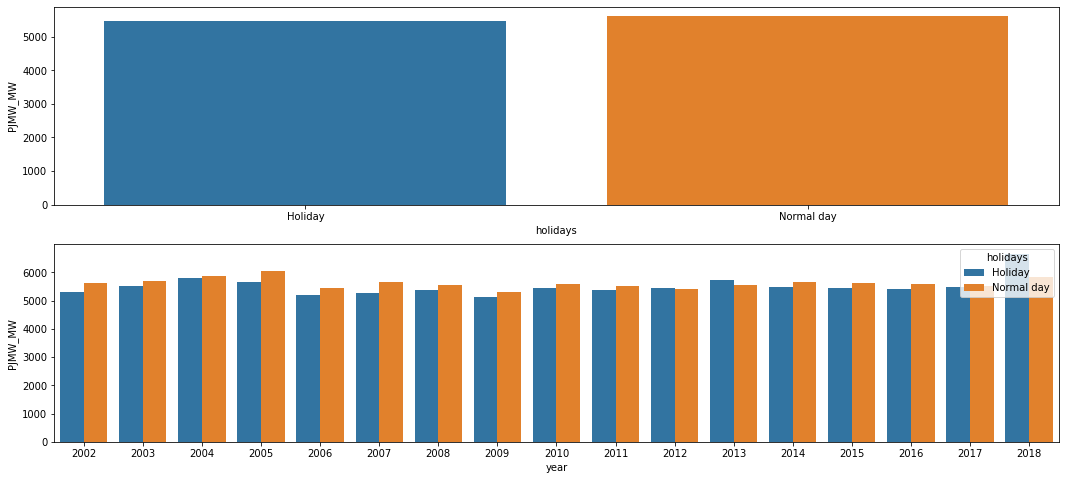

In [70]:
plt.figure(figsize=(18,8))

aux1 = df4[['holidays', 'PJMW_MW']].groupby( 'holidays' ).mean().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='holidays', y='PJMW_MW', data=aux1 )

aux2 = df4[['year', 'holidays', 'PJMW_MW']].groupby( ['year', 'holidays'] ).mean().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='year', y='PJMW_MW', hue='holidays', data=aux2 );

## Decomposition
We will de-compose the time series into trend, seasonal and residuals

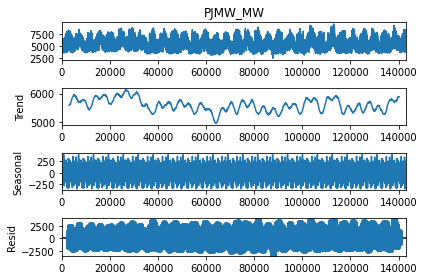

In [71]:
decompose = seasonal_decompose(df4.PJMW_MW,period=6205)
decompose.plot()
plt.show()

This graph gives us an overall trend in our data from year 2002 till year 2018.
Seasonality cannot be checked as the datapoints are too many.

##### Lets resample and aggregate up to weekly level to reduce the noise

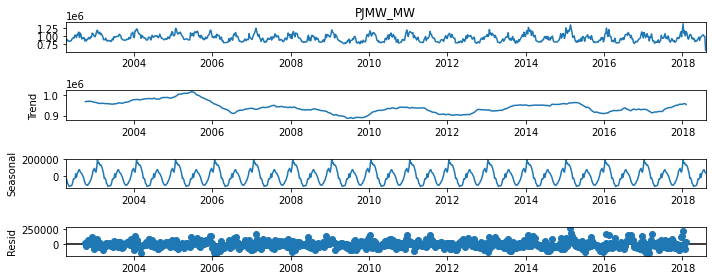

In [55]:
plt.rcParams["figure.figsize"]= (10,4)
weekly_data = df2.PJMW_MW.resample(rule='W').sum()
decomposition = seasonal_decompose(weekly_data, model='additive') # Aggregate to weekly level
fig = decomposition.plot()
plt.show()

Observations:
There is no trend since its not increasing or decreasing.
Seasonal pattern is consistent
Resduals are whetever is left after fitting the trend and seasonal components to the observed data. It's the component we cannot explain. We want the residuals to be i.i.d (i.e uncorrelated). If the residuals have a pattern, it means there is still some structural information left to be captured. Residuals are showing some wavy pattern, which is not good. Let's perform **Ljung Box test** to confirm if they are i.i.d as a group.
We do not want to see any recognizable patterns in the residuals, e.g. waves, upward/downward slope, funnel pattern etc.

### Ljung Box test

In [73]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(df, lags=[1], return_df=True)

,lb_stat,lb_pvalue
1,136113.053316,0.0


Since lb_pvalue < 0.05, residuals are uncorrelated. If the residuals are correlated, we can perform transformations to see if it stabilizes the variance. It's also an indication that we may need to use exogenous variable to fully explain the time series behaviour or use higher order models.
In this case, the residuals are uncorrelated.

#### LAG PLOT

A lag plot is used to help evaluate whether the values in a dataset or time series are random. If the data are random, the lag plot will exhibit no identifiable pattern. If the data are not random, the lag plot will demonstrate a clearly identifiable pattern

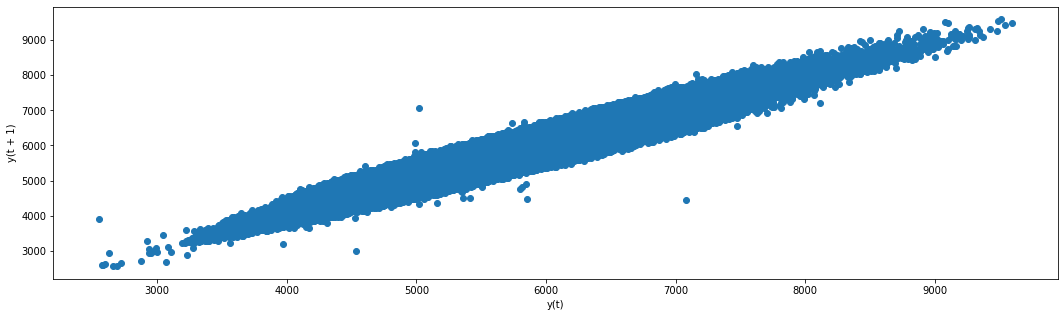

In [62]:
from pandas.plotting import lag_plot
plt.figure(figsize=(18,5))
lag_plot(df2.PJMW_MW)
plt.show()

Our data has Moderate Autocorrelation as the lag plot is in eliptical shape.

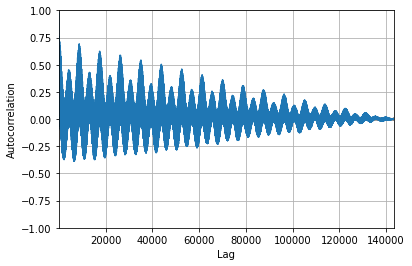

In [75]:

from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df4.PJMW_MW)
plt.show()

# Check for Stationarity

### 1.Constant mean

Mean is: 5602.245472380474


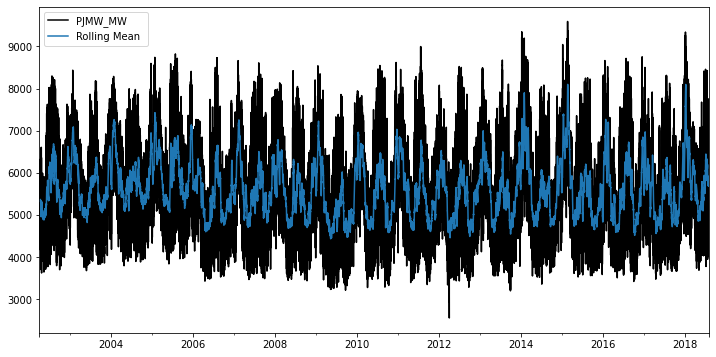

In [76]:
df.plot(figsize=(12,6), legend=True, label="Data", cmap='gray')
df["PJMW_MW"].rolling(200, center=False).mean().plot(legend=True, label="Rolling Mean ");
print("Mean is:", df["PJMW_MW"].mean())

### 2) constant variance

S.D is: 979.1


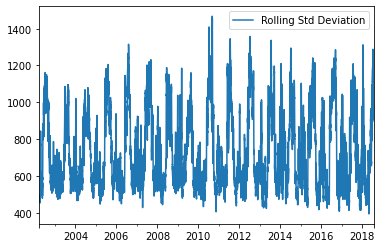

In [77]:
df["PJMW_MW"].rolling(200).std().plot(legend=True, label="Rolling Std Deviation");
print("S.D is:", df["PJMW_MW"].std().round(1))

Both mean and variance are constant.

### Coefficient of Variation:

Coefficient of variation gives us an idea about the variability in the process.

c.v = s.d/mean

If C.V<0.75 => Low Variability

If 0.75<C.V<1.3 => Medium Variability

If C.V>1.3 => High Variability

In [78]:
cv = df["PJMW_MW"].std()/df["PJMW_MW"].mean()
cv.round(2)

0.17

CV < 0.75 Hence its a low variability process

#### Augmented Dickey-fuller test

In [79]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df4.PJMW_MW , autolag= 'AIC')
print("1. ADF :" , dftest[0])
print("2. P-Value :" , dftest[1])
print("3. Num of lags :" , dftest[2])
print("4. No of obs used for ADF regression and critical value calculation :" , dftest[3])
print("5. Critical Values: ")
for key, val in dftest[4].items():
    print("\t",key, ": " , val)

1. ADF : -19.94710429229475
2. P-Value : 0.0
3. Num of lags : 74
4. No of obs used for ADF regression and critical value calculation : 143157
5. Critical Values: 
	 1% :  -3.4303956800384174
	 5% :  -2.861560189928386
	 10% :  -2.5667807463806995


Our p-value is definitely less than 0.05 and so we can say with pretty good confidence that we can reject the null (unit root, non-stationary data) and can assume our data is stationary.

### ACF & PACF Plot

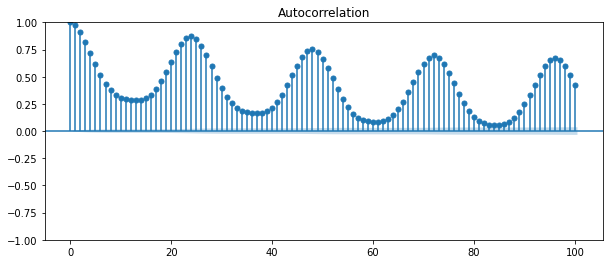

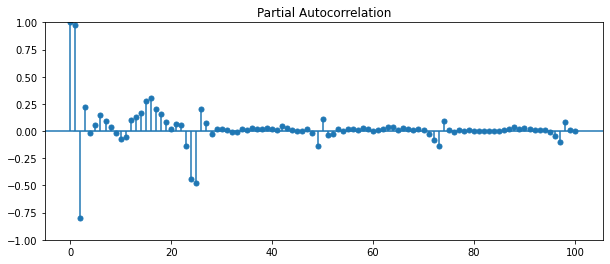

In [64]:
tsa_plots.plot_acf(df4.PJMW_MW,lags=100)
tsa_plots.plot_pacf(df4.PJMW_MW,lags=100)
plt.show()

#### Downsample data to daily basis

In [212]:
daily_data = df2.resample(rule='D').mean()
daily_data = daily_data.asfreq('D')

In [67]:
daily_data.head(5)

,PJMW_MW
Datetime,
2002-04-01,5271.173913
2002-04-02,5310.416667
2002-04-03,5325.916667
2002-04-04,5670.791667
2002-04-05,5686.125000


### Differencing the daily data to remove seasonality

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


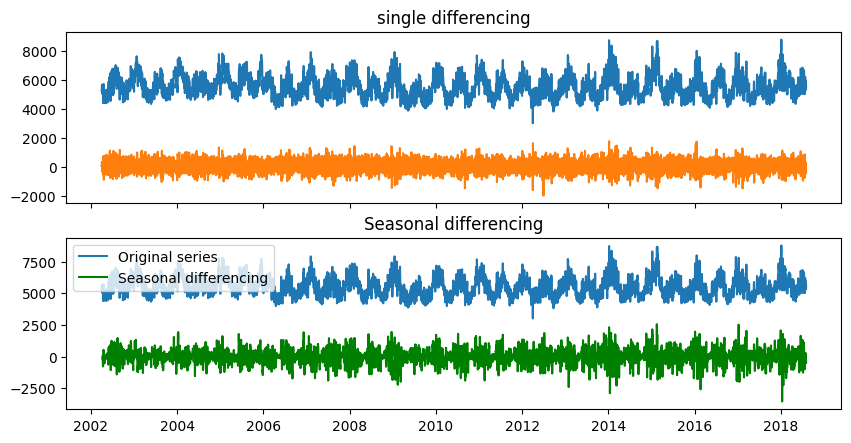

In [312]:
fig, axes = plt.subplots(2,1,figsize=(10,5),dpi=100,sharex=True)
data=daily_data.PJMW_MW
axes[0].plot(data[:], label = "Original series")
axes[0].plot(data[:].diff(1), label = "single differencing")
axes[0].set_title("single differencing")
plt.legend(loc='upper left', fontsize=10)

#Second differencing with 7 lags

axes[1].plot(data[:], label = "Original series")
axes[1].plot(data[:].diff(7), label = "Seasonal differencing",color='green')
axes[1].set_title("Seasonal differencing")
plt.legend(loc='upper left', fontsize=10)

plt.show()

c:\users\ankit\appdata\local\programs\python\python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


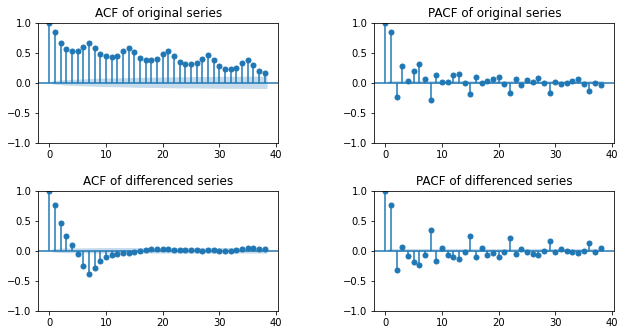

In [309]:
fig,axes = plt.subplots(2,2,figsize=(10,5))
tsa_plots.plot_acf(daily_data, ax=axes[0,0]); axes[0,0].set_title('ACF of original series')
tsa_plots.plot_pacf(daily_data, ax=axes[0,1]); axes[0,1].set_title('PACF of original series')

#differencing
tsa_plots.plot_acf(daily_data.diff(7).dropna(), ax=axes[1,0]); axes[1,0].set_title('ACF of differenced series')
tsa_plots.plot_pacf(daily_data.diff(7).dropna(), ax=axes[1,1]); axes[1,1].set_title('PACF of differenced series')

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

### Double Differencing

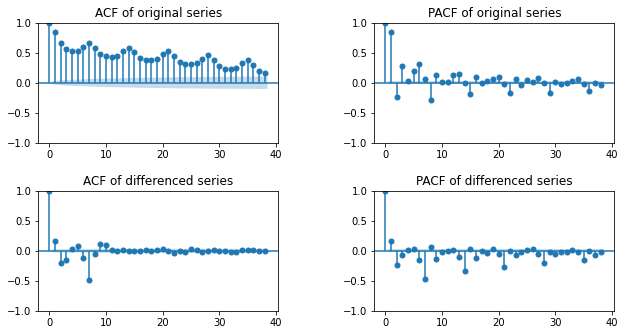

In [310]:
fig,axes = plt.subplots(2,2,figsize=(10,5))
tsa_plots.plot_acf(daily_data, ax=axes[0,0]); axes[0,0].set_title('ACF of original series')
tsa_plots.plot_pacf(daily_data, ax=axes[0,1]); axes[0,1].set_title('PACF of original series')

#differencing
tsa_plots.plot_acf(daily_data.diff(7).diff().dropna(), ax=axes[1,0]); axes[1,0].set_title('ACF of differenced series')
tsa_plots.plot_pacf(daily_data.diff(7).diff().dropna(), ax=axes[1,1]); axes[1,1].set_title('PACF of differenced series')

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

# SARIMA MODEL

### Split train and test

In [213]:
# First we split it up between train and test
# We will aim for a 12 month forecast horizon (ie predict the last 12 months in the dataset)
cutoff = '2017-08-04'

daily_data.sort_index()

train = daily_data[:cutoff]
test = daily_data[cutoff:]

In [87]:
train.shape,test.shape

((5605, 1), (365, 1))

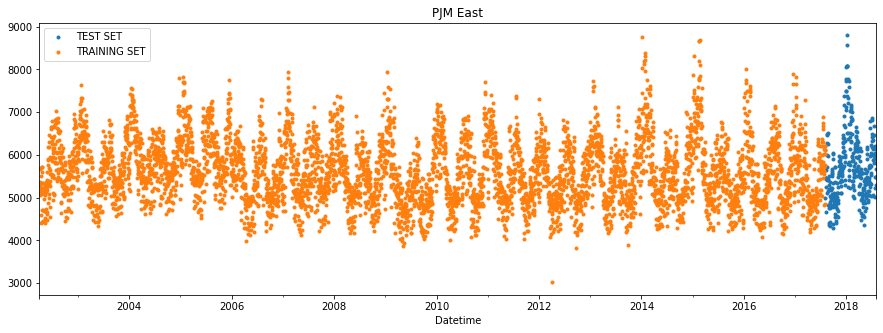

In [88]:
# Plot train and test so you can see where we have split
test.rename(columns={'PJMW_MW': 'TEST SET'}).join(train.rename(columns={'PJMW_MW': 'TRAINING SET'}),
          how='outer').plot(figsize=(15,5), title='PJM East', style='.')
plt.show()

### Diff 7

c:\users\ankit\appdata\local\programs\python\python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


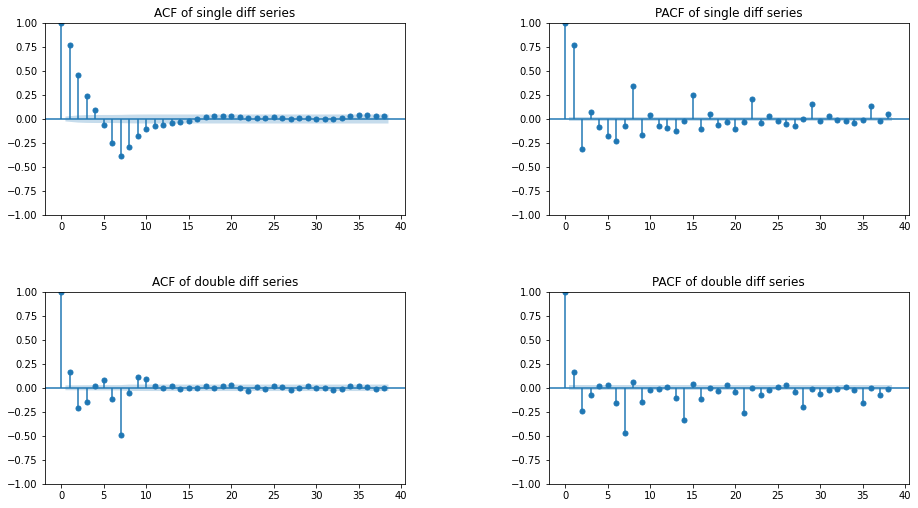

In [73]:
fig,axes = plt.subplots(2,2,figsize=(15,8))
tsa_plots.plot_acf(daily_data.diff(7).dropna(), ax=axes[0,0]); axes[0,0].set_title('ACF of single diff series')
tsa_plots.plot_pacf(daily_data.diff(7).dropna(), ax=axes[0,1]); axes[0,1].set_title('PACF of single diff series')

#differencing
tsa_plots.plot_acf(daily_data.diff(7).diff().dropna(), ax=axes[1,0]); axes[1,0].set_title('ACF of double diff series')
tsa_plots.plot_pacf(daily_data.diff(7).diff().dropna(), ax=axes[1,1]); axes[1,1].set_title('PACF of double diff series')

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

p=1 q=3 P=1 Q=0

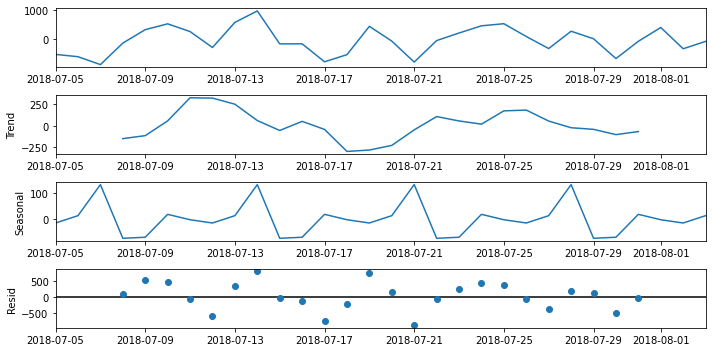

In [74]:
diff7=daily_data.diff(7).diff().dropna()
plt.rcParams['figure.figsize'] = [10, 5]
decomposition = seasonal_decompose(diff7[-30:], model='additive') # Aggregate to weekly level
decomposition.plot()
plt.show()


In [75]:
model_7=sm.tsa.statespace.SARIMAX(train,order=(1,1,3),seasonal_order=(1,1,0,7))
fitted_7 = model_7.fit(disp=-1)
print(fitted_7.summary())

c:\users\ankit\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\ankit\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                     SARIMAX Results                                      
Dep. Variable:                            PJMW_MW   No. Observations:                 5605
Model:             SARIMAX(1, 1, 3)x(1, 1, [], 7)   Log Likelihood              -40300.003
Date:                            Mon, 10 Oct 2022   AIC                          80612.005
Time:                                    23:54:01   BIC                          80651.785
Sample:                                04-01-2002   HQIC                         80625.868
                                     - 08-04-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6305      0.017     37.554      0.000       0.598       0.663
ma.L1         -0.5792      1.801   

In [76]:
n_steps = 365
fc7 = fitted_7.forecast(n_steps,alpha=0.05)

## Model Evaluation

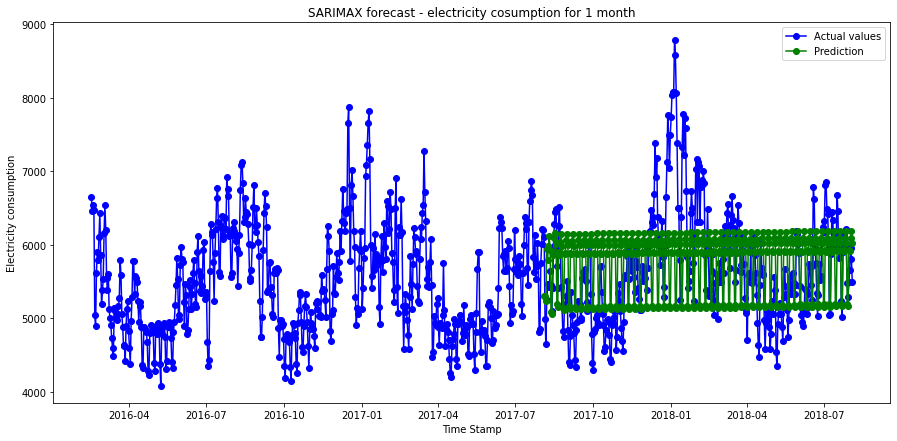

In [77]:

fitted_series7 = pd.Series(fc7,index=test.index)
fitted_series7=fitted_series7.bfill(axis ='rows')
fig, ax = plt.subplots(figsize=(15,7))
# plt.plot(daily_data)
plt.plot(daily_data[-900:].index,daily_data[-900:].values, label='Actual values', color="blue", marker="o")
plt.plot(fitted_series7[-365:].index, fitted_series7[-365:].values,label='Prediction', color="green", marker="o")

# plt.plot(fitted_series)

plt.title("SARIMAX forecast - electricity cosumption for 1 month")
plt.xlabel("Time Stamp")
plt.ylabel("Electricity consumption")
plt.legend()

plt.show()

In [77]:
def mape(forecast,actual):
    mape=round(np.mean(np.abs(forecast - actual)/np.abs(actual))*100,2)
    return mape

In [78]:
def mae(forecast,actual):
    mae=round(np.mean(np.abs(forecast - actual)),2)
    return mae

In [79]:
def rmse(forecast,actual):
    rmse = round(np.mean(np.abs(forecast - actual)**2)**.5,2)
    return rmse

In [81]:
MAPE_7= mape(fitted_series7.values, test.values)
MAE_7= mae(fitted_series7.values, test.values)
print("MAPE_7: ",MAPE_7)
print("MAE_7: ",MAE_7)

MAPE_7:  12.06
MAE_7:  684.23


In [83]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_7=sqrt((mean_squared_error(fitted_series7.values,test.values)))
rmse_7

767.3478423962943

### Diff 30

c:\users\ankit\appdata\local\programs\python\python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


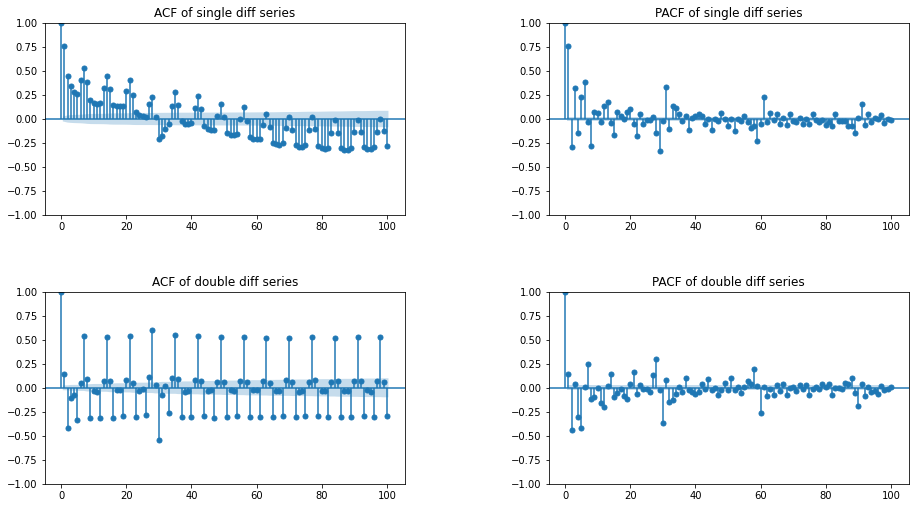

In [99]:
fig,axes = plt.subplots(2,2,figsize=(15,8))
tsa_plots.plot_acf(daily_data.diff(30).dropna(), ax=axes[0,0],lags=100); axes[0,0].set_title('ACF of single diff series')
tsa_plots.plot_pacf(daily_data.diff(30).dropna(), ax=axes[0,1],lags=100); axes[0,1].set_title('PACF of single diff series')

#differencing
tsa_plots.plot_acf(daily_data.diff(30).diff().dropna(), ax=axes[1,0],lags=100); axes[1,0].set_title('ACF of double diff series')
tsa_plots.plot_pacf(daily_data.diff(30).diff().dropna(), ax=axes[1,1],lags=100); axes[1,1].set_title('PACF of double diff series')

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

## Diff 70

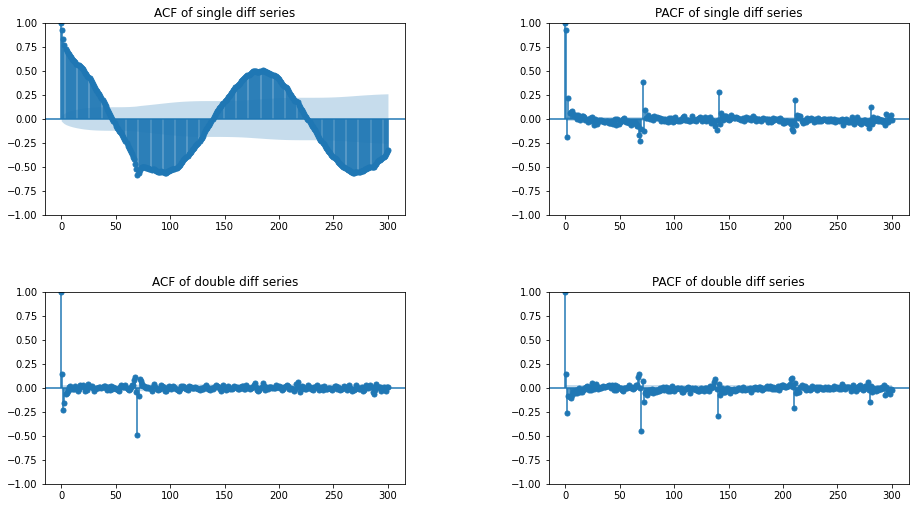

In [100]:
fig,axes = plt.subplots(2,2,figsize=(15,8))
tsa_plots.plot_acf(daily_data.diff(70).dropna(), ax=axes[0,0],lags=300); axes[0,0].set_title('ACF of single diff series')
tsa_plots.plot_pacf(daily_data.diff(70).dropna(), ax=axes[0,1],lags=300); axes[0,1].set_title('PACF of single diff series')

#differencing
tsa_plots.plot_acf(daily_data.diff(70).diff().dropna(), ax=axes[1,0],lags=300); axes[1,0].set_title('ACF of double diff series')
tsa_plots.plot_pacf(daily_data.diff(70).diff().dropna(), ax=axes[1,1],lags=300); axes[1,1].set_title('PACF of double diff series')

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

In [72]:
data_10year=daily_data['2008-01-01':'2017-08-03']

In [73]:
data_10year

,PJMW_MW
Datetime,
2008-01-01,5657.125000
2008-01-02,6920.250000
2008-01-03,7223.416667
2008-01-04,6963.250000
2008-01-05,6016.958333
...,...
2017-07-30,4859.875000
2017-07-31,5757.750000
2017-08-01,6015.666667


In [320]:
model_70=sm.tsa.statespace.SARIMAX(data_10year,order=(2,1,3),seasonal_order=(1,1,0,70))
fitted_70 = model_70.fit(disp=-1)
print(fitted_70.summary())

c:\users\ankit\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                             PJMW_MW   No. Observations:                 3503
Model:             SARIMAX(2, 1, 3)x(1, 1, [], 70)   Log Likelihood              -25010.905
Date:                             Mon, 10 Oct 2022   AIC                          50035.810
Time:                                     19:01:09   BIC                          50078.796
Sample:                                 01-01-2008   HQIC                         50051.166
                                      - 08-03-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5015      0.040     37.140      0.000       1.422       1.581
ar.L2         -0.5118      

In [321]:
n_steps = 365
fc70 = fitted_70.forecast(n_steps,alpha=0.05)

## Evaluvate Model

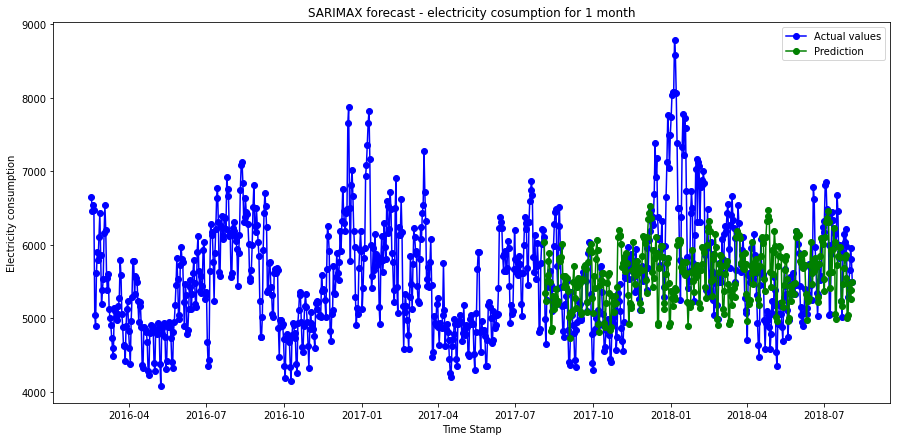

In [322]:

fitted_series70 = pd.Series(fc70,index=test.index)
fitted_series70=fitted_series70.bfill(axis ='rows')
fig, ax = plt.subplots(figsize=(15,7))
# plt.plot(daily_data)
plt.plot(daily_data[-900:].index,daily_data[-900:].values, label='Actual values', color="blue", marker="o")
plt.plot(fitted_series70[-365:].index, fitted_series70[-365:].values,label='Prediction', color="green", marker="o")

# plt.plot(fitted_series)

plt.title("SARIMAX forecast - electricity cosumption for 1 month")
plt.xlabel("Time Stamp")
plt.ylabel("Electricity consumption")
plt.legend()

plt.show()

In [323]:
MAPE_70= mape(fitted_series70.values, test.values)
MAE_70= mae(fitted_series70.values, test.values)
print("MAPE_70: ",MAPE_70)
print("MAE_70: ",MAE_70)

MAPE_70:  11.32
MAE_70:  658.15


In [324]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_70=sqrt((mean_squared_error(fitted_series70.values,test.values)))
rmse_70

788.662673335869

### Diff 90

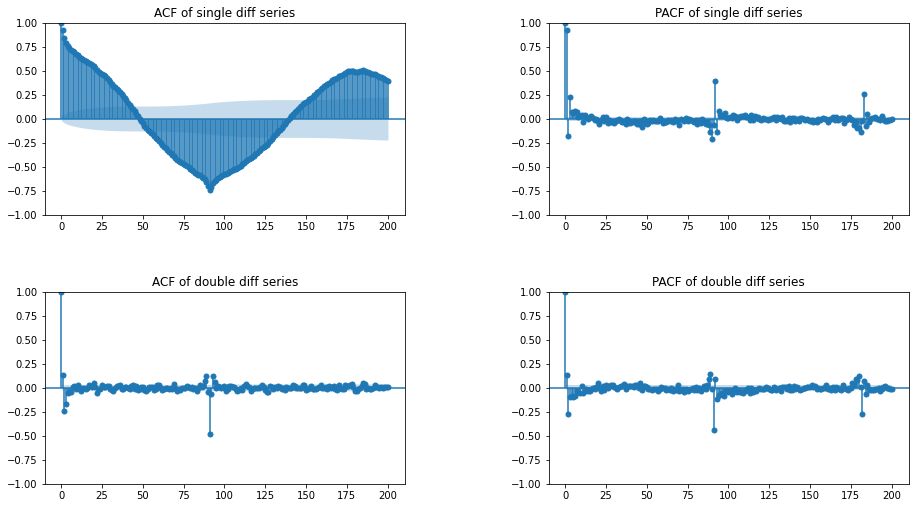

In [78]:
fig,axes = plt.subplots(2,2,figsize=(15,8))
tsa_plots.plot_acf(daily_data.diff(91).dropna(), ax=axes[0,0],lags=200); axes[0,0].set_title('ACF of single diff series')
tsa_plots.plot_pacf(daily_data.diff(91).dropna(), ax=axes[0,1],lags=200); axes[0,1].set_title('PACF of single diff series')

#differencing
tsa_plots.plot_acf(daily_data.diff(91).diff().dropna(), ax=axes[1,0],lags=200); axes[1,0].set_title('ACF of double diff series')
tsa_plots.plot_pacf(daily_data.diff(91).diff().dropna(), ax=axes[1,1],lags=200); axes[1,1].set_title('PACF of double diff series')

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

p=2,q=3,P=1,q=0

In [94]:
model_90=sm.tsa.statespace.SARIMAX(train,order=(2,1,3),seasonal_order=(1,1,0,91))
fitted_90 = model_90.fit(low_memory=True,cov_type='approx')
print(fitted_90.summary())

c:\users\ankit\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                             PJMW_MW   No. Observations:                 5605
Model:             SARIMAX(2, 1, 3)x(1, 1, [], 91)   Log Likelihood              -39864.150
Date:                             Tue, 11 Oct 2022   AIC                          79742.300
Time:                                     21:17:13   BIC                          79788.604
Sample:                                 04-01-2002   HQIC                         79758.449
                                      - 08-04-2017                                         
Covariance Type:                            approx                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5451      0.019     80.211      0.000       1.507       1.583
ar.L2         -0.5541      

In [95]:
n_steps = 365
fc90 = fitted_90.forecast(n_steps,alpha=0.05)

## Evaluate model

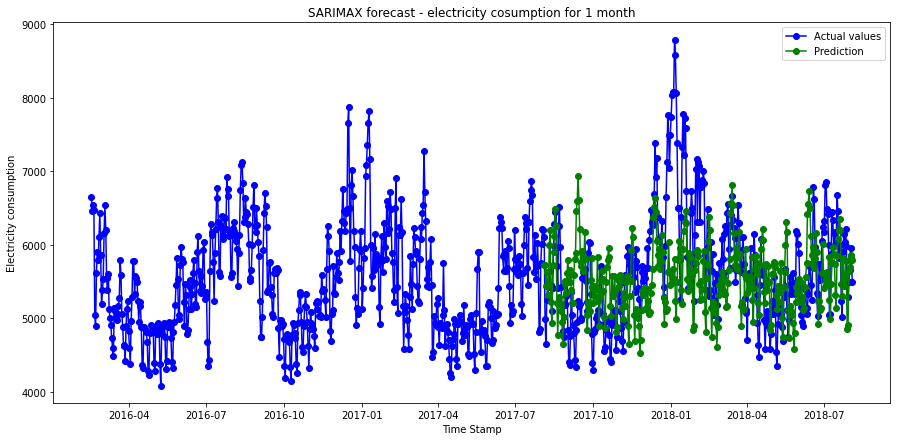

In [96]:
fitted_series90 = pd.Series(fc90,index=test.index)
fitted_series90=fitted_series90.bfill(axis ='rows')
fig, ax = plt.subplots(figsize=(15,7))
# plt.plot(daily_data)
plt.plot(daily_data[-900:].index,daily_data[-900:].values, label='Actual values', color="blue", marker="o")
plt.plot(fitted_series90[-365:].index, fitted_series90[-365:].values,label='Prediction', color="green", marker="o")

# plt.plot(fitted_series)

plt.title("SARIMAX forecast - electricity cosumption for 1 month")
plt.xlabel("Time Stamp")
plt.ylabel("Electricity consumption")
plt.legend()

plt.show()

In [97]:
MAPE_90= mape(fitted_series90.values, test.values)
MAE_90= mae(fitted_series90.values, test.values)
print("MAPE_90: ",MAPE_90)
print("MAE_90: ",MAE_90)

MAPE_90:  11.73
MAE_90:  686.67


In [99]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_90=sqrt((mean_squared_error(fitted_series90.values,test.values)))
rmse_90

785.5788509450377

### Diff 120

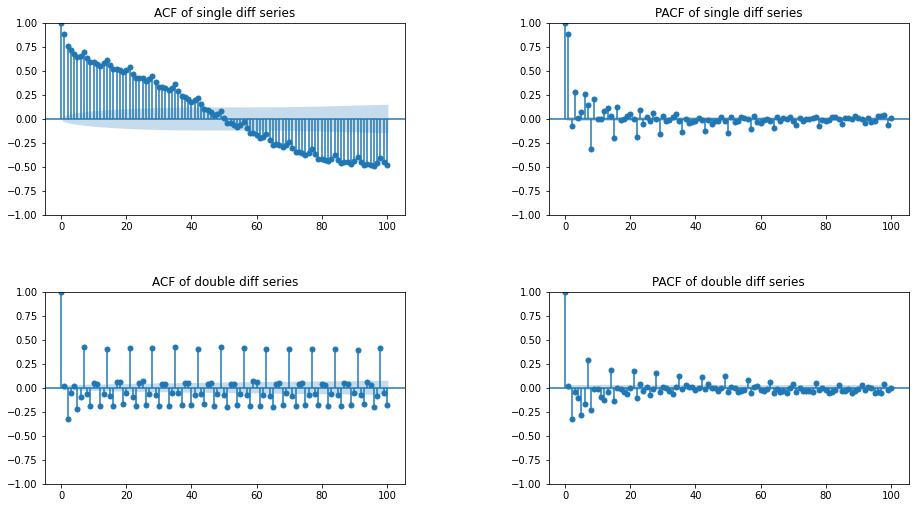

In [108]:
fig,axes = plt.subplots(2,2,figsize=(15,8))
tsa_plots.plot_acf(daily_data.diff(120).dropna(), ax=axes[0,0],lags=100); axes[0,0].set_title('ACF of single diff series')
tsa_plots.plot_pacf(daily_data.diff(120).dropna(), ax=axes[0,1],lags=100); axes[0,1].set_title('PACF of single diff series')

#differencing
tsa_plots.plot_acf(daily_data.diff(120).diff().dropna(), ax=axes[1,0],lags=100); axes[1,0].set_title('ACF of double diff series')
tsa_plots.plot_pacf(daily_data.diff(120).diff().dropna(), ax=axes[1,1],lags=100); axes[1,1].set_title('PACF of double diff series')

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

### Diff 140

c:\users\ankit\appdata\local\programs\python\python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


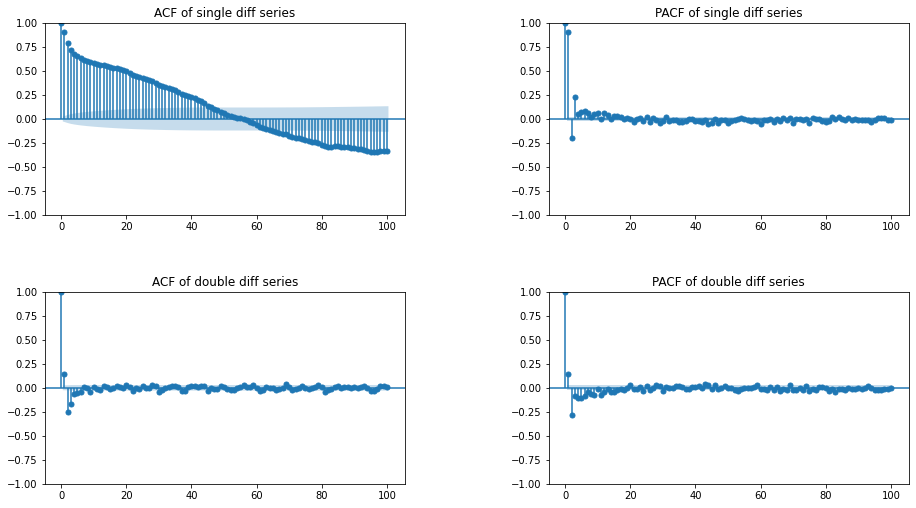

In [84]:
fig,axes = plt.subplots(2,2,figsize=(15,8))
tsa_plots.plot_acf(daily_data.diff(140).dropna(), ax=axes[0,0],lags=100); axes[0,0].set_title('ACF of single diff series')
tsa_plots.plot_pacf(daily_data.diff(140).dropna(), ax=axes[0,1],lags=100); axes[0,1].set_title('PACF of single diff series')

#differencing
tsa_plots.plot_acf(daily_data.diff(140).diff().dropna(), ax=axes[1,0],lags=100); axes[1,0].set_title('ACF of double diff series')
tsa_plots.plot_pacf(daily_data.diff(140).diff().dropna(), ax=axes[1,1],lags=100); axes[1,1].set_title('PACF of double diff series')

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

p=2,q=3,Q=0,P=0

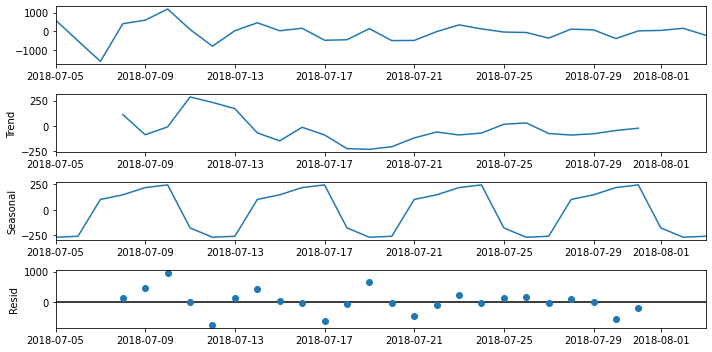

In [85]:
diff140=daily_data.diff(140).diff().dropna()
plt.rcParams['figure.figsize'] = [10, 5]
decomposition = seasonal_decompose(diff140[-30:], model='additive') # Aggregate to weekly level
decomposition.plot()
plt.show()

In [86]:
data_3year=daily_data['2015-08-03':'2017-08-03']

In [87]:
model_140=sm.tsa.statespace.SARIMAX(data_3year,order=(2,1,3),seasonal_order=(1,1,0,140))
fitted_140 = model_140.fit(disp=-1)
print(fitted_140.summary())

                                      SARIMAX Results                                       
Dep. Variable:                              PJMW_MW   No. Observations:                  732
Model:             SARIMAX(2, 1, 3)x(1, 1, [], 140)   Log Likelihood               -4334.322
Date:                              Tue, 11 Oct 2022   AIC                           8682.645
Time:                                      00:09:53   BIC                           8713.317
Sample:                                  08-03-2015   HQIC                          8694.593
                                       - 08-03-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6828      0.422      1.617      0.106      -0.145       1.510
ar.L2         -0.13

In [93]:
n_steps = 365
fc140 = fitted_140.forecast(n_steps,alpha=0.05)

## Evaluate the model

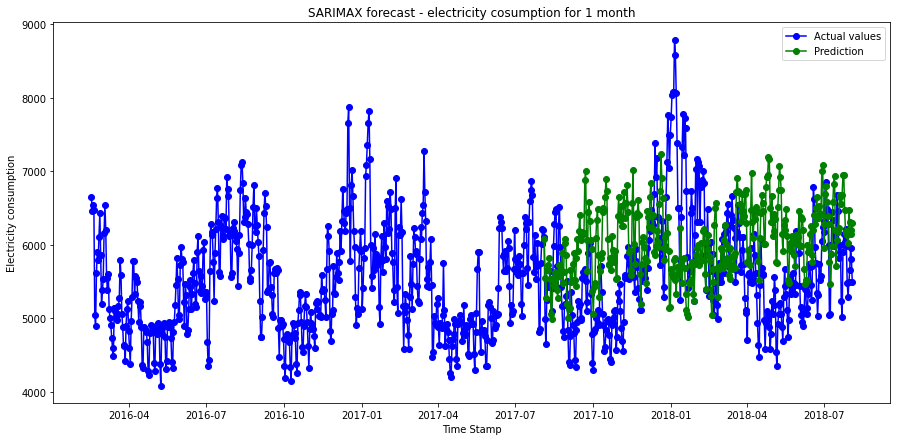

In [94]:
fitted_series140 = pd.Series(fc140,index=test.index)
fitted_series140=fitted_series140.bfill(axis ='rows')
fig, ax = plt.subplots(figsize=(15,7))
# plt.plot(daily_data)
plt.plot(daily_data[-900:].index,daily_data[-900:].values, label='Actual values', color="blue", marker="o")
plt.plot(fitted_series140[-365:].index, fitted_series140[-365:].values,label='Prediction', color="green", marker="o")

# plt.plot(fitted_series)

plt.title("SARIMAX forecast - electricity cosumption for 1 month")
plt.xlabel("Time Stamp")
plt.ylabel("Electricity consumption")
plt.legend()

plt.show()

In [95]:
MAPE_140= mape(fitted_series140.values, test.values)
MAE_140= mae(fitted_series140.values, test.values)
print("MAPE_140: ",MAPE_140)
print("MAE_140: ",MAE_140)

MAPE_140:  14.17
MAE_140:  780.78


In [96]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_140=sqrt((mean_squared_error(fitted_series140.values,test.values)))
rmse_140

974.0461745188588

# Diff 365

c:\users\ankit\appdata\local\programs\python\python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


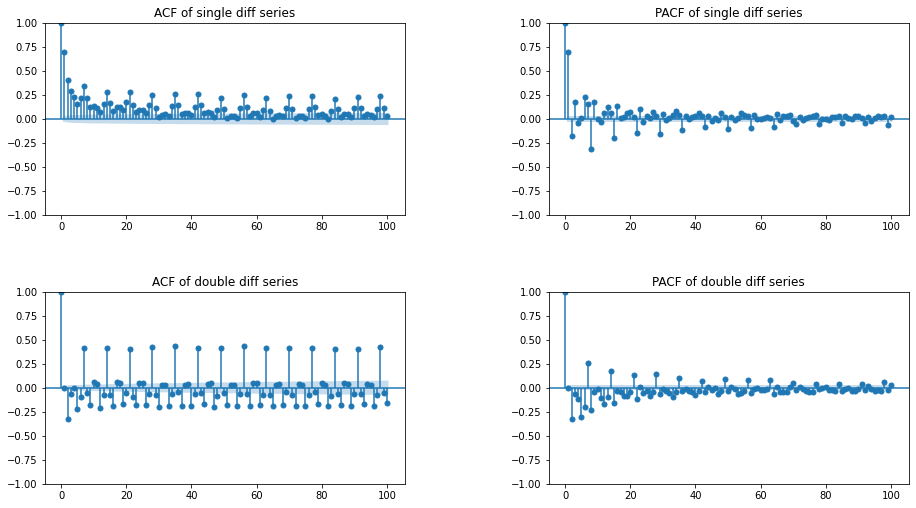

In [104]:
fig,axes = plt.subplots(2,2,figsize=(15,8))
tsa_plots.plot_acf(daily_data.diff(365).dropna(), ax=axes[0,0],lags=100); axes[0,0].set_title('ACF of single diff series')
tsa_plots.plot_pacf(daily_data.diff(365).dropna(), ax=axes[0,1],lags=100); axes[0,1].set_title('PACF of single diff series')

#differencing
tsa_plots.plot_acf(daily_data.diff(365).diff().dropna(), ax=axes[1,0],lags=100); axes[1,0].set_title('ACF of double diff series')
tsa_plots.plot_pacf(daily_data.diff(365).diff().dropna(), ax=axes[1,1],lags=100); axes[1,1].set_title('PACF of double diff series')

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

### Diff 364

c:\users\ankit\appdata\local\programs\python\python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


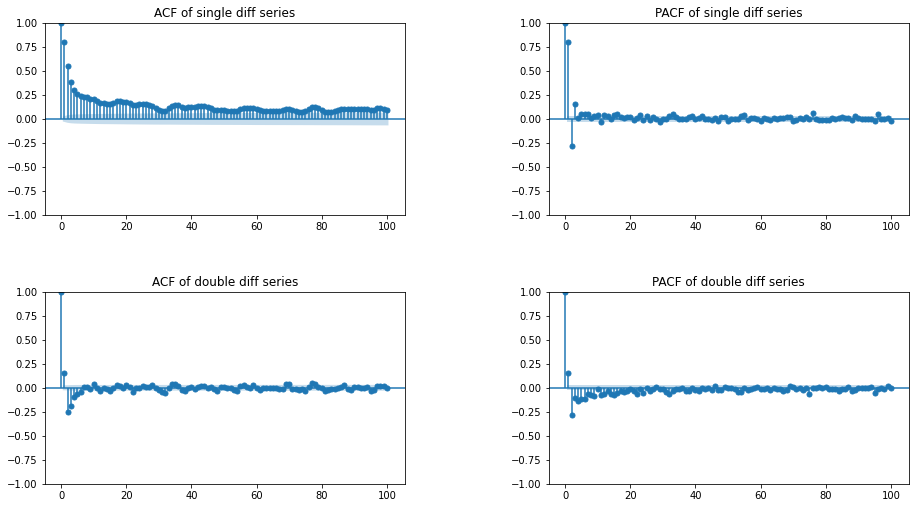

In [75]:
fig,axes = plt.subplots(2,2,figsize=(15,8))
tsa_plots.plot_acf(daily_data.diff(364).dropna(), ax=axes[0,0],lags=100); axes[0,0].set_title('ACF of single diff series')
tsa_plots.plot_pacf(daily_data.diff(364).dropna(), ax=axes[0,1],lags=100); axes[0,1].set_title('PACF of single diff series')

#differencing
tsa_plots.plot_acf(daily_data.diff(364).diff().dropna(), ax=axes[1,0],lags=100); axes[1,0].set_title('ACF of double diff series')
tsa_plots.plot_pacf(daily_data.diff(364).diff().dropna(), ax=axes[1,1],lags=100); axes[1,1].set_title('PACF of double diff series')

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

p=2,q=3,P=1,Q=0

In [72]:
data_2year=daily_data['2015-08-03':'2017-08-03']

In [73]:
model_364=sm.tsa.statespace.SARIMAX(data_2year,order=(3,1,3),seasonal_order=(1,1,0,364))
fitted_364 = model_364.fit(low_memory=True,cov_type='approx')
print(fitted_364.summary())

                                      SARIMAX Results                                       
Dep. Variable:                              PJMW_MW   No. Observations:                  732
Model:             SARIMAX(3, 1, 3)x(1, 1, [], 364)   Log Likelihood               -2697.475
Date:                              Thu, 13 Oct 2022   AIC                           5410.950
Time:                                      12:19:47   BIC                           5442.193
Sample:                                  08-03-2015   HQIC                          5423.364
                                       - 08-03-2017                                         
Covariance Type:                             approx                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.0089      0.058     34.574      0.000       1.895       2.123
ar.L2         -1.32

In [74]:
n_steps = 365
fc364 = fitted_364.forecast(n_steps,alpha=0.05)

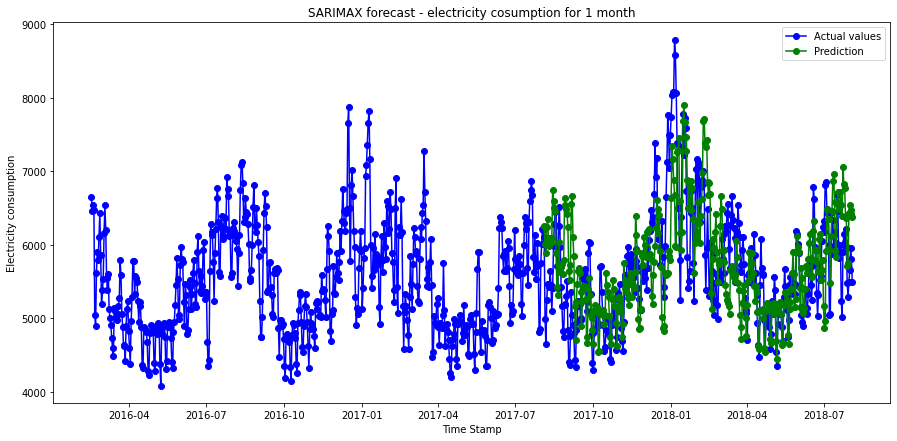

In [75]:
fitted_series364 = pd.Series(fc364,index=test.index)
fitted_series364=fitted_series364.bfill(axis ='rows')
fig, ax = plt.subplots(figsize=(15,7))
# plt.plot(daily_data)
plt.plot(daily_data[-900:].index,daily_data[-900:].values, label='Actual values', color="blue", marker="o")
plt.plot(fitted_series364[-365:].index, fitted_series364[-365:].values,label='Prediction', color="green", marker="o")

# plt.plot(fitted_series)

plt.title("SARIMAX forecast - electricity cosumption for 1 month")
plt.xlabel("Time Stamp")
plt.ylabel("Electricity consumption")
plt.legend()

plt.show()

In [80]:
MAPE_364= mape(fitted_series364.values, test.values)
MAE_364= mae(fitted_series364.values, test.values)
print("MAPE_364: ",MAPE_364)
print("MAE_364: ",MAE_364)

MAPE_364:  14.07
MAE_364:  802.73


In [81]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_364=sqrt((mean_squared_error(fitted_series364.values,test.values)))
rmse_364

678.8247080893625

# REGRESSION MODEL

<AxesSubplot:>

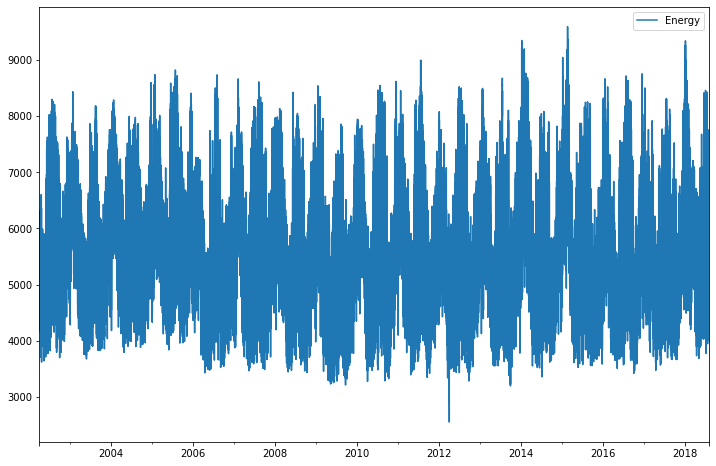

In [214]:
df.columns = ['Energy']
df.plot(figsize=(12,8))

In [215]:
daily_data = df.resample(rule='D').mean()
daily_data = daily_data.asfreq('D')

In [79]:
daily_data

,Energy
2002-04-01,5271.173913
2002-04-02,5310.416667
2002-04-03,5325.916667
2002-04-04,5670.791667
2002-04-05,5686.125000
...,...
2018-07-30,5492.708333
2018-07-31,5660.750000
2018-08-01,5959.708333
2018-08-02,5805.041667


In [216]:
daily_data1=daily_data.copy()

In [217]:
daily_data['energy_1dayback']=daily_data['Energy'].shift(+1)
daily_data['energy_2dayback']=daily_data['Energy'].shift(+2)
daily_data['energy_3dayback']=daily_data['Energy'].shift(+3)
daily_data['energy_4dayback']=daily_data['Energy'].shift(+4)
daily_data['energy_5dayback']=daily_data['Energy'].shift(+5)
daily_data['energy_6dayback']=daily_data['Energy'].shift(+6)
daily_data['energy_7dayback']=daily_data['Energy'].shift(+7)

daily_data.head(10)

,Energy,energy_1dayback,energy_2dayback,energy_3dayback,energy_4dayback,energy_5dayback,energy_6dayback,energy_7dayback
2002-04-01,5271.173913,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-04-02,5310.416667,5271.173913,NaN,NaN,NaN,NaN,NaN,NaN
2002-04-03,5325.916667,5310.416667,5271.173913,NaN,NaN,NaN,NaN,NaN
2002-04-04,5670.791667,5325.916667,5310.416667,5271.173913,NaN,NaN,NaN,NaN
2002-04-05,5686.125000,5670.791667,5325.916667,5310.416667,5271.173913,NaN,NaN,NaN
2002-04-06,5367.791667,5686.125000,5670.791667,5325.916667,5310.416667,5271.173913,NaN,NaN
2002-04-07,5052.479167,5367.791667,5686.125000,5670.791667,5325.916667,5310.416667,5271.173913,NaN
2002-04-08,5283.875000,5052.479167,5367.791667,5686.125000,5670.791667,5325.916667,5310.416667,5271.173913
2002-04-09,5136.083333,5283.875000,5052.479167,5367.791667,5686.125000,5670.791667,5325.916667,5310.416667
2002-04-10,5171.666667,5136.083333,5283.875000,5052.479167,5367.791667,5686.125000,5670.791667,5325.916667


In [218]:
daily_data=daily_data.dropna()
daily_data

,Energy,energy_1dayback,energy_2dayback,energy_3dayback,energy_4dayback,energy_5dayback,energy_6dayback,energy_7dayback
2002-04-08,5283.875000,5052.479167,5367.791667,5686.125000,5670.791667,5325.916667,5310.416667,5271.173913
2002-04-09,5136.083333,5283.875000,5052.479167,5367.791667,5686.125000,5670.791667,5325.916667,5310.416667
2002-04-10,5171.666667,5136.083333,5283.875000,5052.479167,5367.791667,5686.125000,5670.791667,5325.916667
2002-04-11,5207.875000,5171.666667,5136.083333,5283.875000,5052.479167,5367.791667,5686.125000,5670.791667
2002-04-12,5090.416667,5207.875000,5171.666667,5136.083333,5283.875000,5052.479167,5367.791667,5686.125000
...,...,...,...,...,...,...,...,...
2018-07-30,5492.708333,5293.833333,5485.791667,5978.750000,6216.458333,6036.208333,6142.666667,5900.041667
2018-07-31,5660.750000,5492.708333,5293.833333,5485.791667,5978.750000,6216.458333,6036.208333,6142.666667
2018-08-01,5959.708333,5660.750000,5492.708333,5293.833333,5485.791667,5978.750000,6216.458333,6036.208333
2018-08-02,5805.041667,5959.708333,5660.750000,5492.708333,5293.833333,5485.791667,5978.750000,6216.458333


In [219]:
daily_data1.to_csv('dataset_daily.csv')

In [220]:
import numpy as np
x1,x2,x3,x4,x5,x6,x7,y=daily_data['energy_1dayback'],daily_data['energy_2dayback'],daily_data['energy_3dayback'],daily_data['energy_4dayback'],daily_data['energy_5dayback'],daily_data['energy_6dayback'],daily_data['energy_7dayback'],daily_data['Energy']
x1,x2,x3,x4,x5,x6,x7,y=np.array(x1),np.array(x2),np.array(x3),np.array(x4),np.array(x5),np.array(x6),np.array(x7),np.array(y)
x1,x2,x3,x4,x5,x6,x7,y=x1.reshape(-1,1),x2.reshape(-1,1),x3.reshape(-1,1),x4.reshape(-1,1),x5.reshape(-1,1),x6.reshape(-1,1),x7.reshape(-1,1),y.reshape(-1,1)
final_x=np.concatenate((x1,x2,x3,x4,x5,x6,x7),axis=1)
print(final_x)

[[5052.47916667 5367.79166667 5686.125      ... 5325.91666667
  5310.41666667 5271.17391304]
 [5283.875      5052.47916667 5367.79166667 ... 5670.79166667
  5325.91666667 5310.41666667]
 [5136.08333333 5283.875      5052.47916667 ... 5686.125
  5670.79166667 5325.91666667]
 ...
 [5660.75       5492.70833333 5293.83333333 ... 5978.75
  6216.45833333 6036.20833333]
 [5959.70833333 5660.75       5492.70833333 ... 5485.79166667
  5978.75       6216.45833333]
 [5805.04166667 5959.70833333 5660.75       ... 5293.83333333
  5485.79166667 5978.75      ]]


In [221]:
final_x

array([[5052.47916667, 5367.79166667, 5686.125     , ..., 5325.91666667,
        5310.41666667, 5271.17391304],
       [5283.875     , 5052.47916667, 5367.79166667, ..., 5670.79166667,
        5325.91666667, 5310.41666667],
       [5136.08333333, 5283.875     , 5052.47916667, ..., 5686.125     ,
        5670.79166667, 5325.91666667],
       ...,
       [5660.75      , 5492.70833333, 5293.83333333, ..., 5978.75      ,
        6216.45833333, 6036.20833333],
       [5959.70833333, 5660.75      , 5492.70833333, ..., 5485.79166667,
        5978.75      , 6216.45833333],
       [5805.04166667, 5959.70833333, 5660.75      , ..., 5293.83333333,
        5485.79166667, 5978.75      ]])

In [222]:
y

array([[5283.875     ],
       [5136.08333333],
       [5171.66666667],
       ...,
       [5959.70833333],
       [5805.04166667],
       [5489.        ]])

In [223]:
X_train,X_test,y_train,y_test=final_x[:-360],final_x[-360:],y[:-360],y[-360:]


# LR, RF and XGB Model

In [224]:
from sklearn.linear_model import LinearRegression
lin_model=LinearRegression()

In [225]:
from sklearn.ensemble import RandomForestRegressor
ran_model=RandomForestRegressor(n_estimators=100,max_features=3, random_state=1)

In [226]:
ran_model.fit(X_train,y_train)
lin_model.fit(X_train,y_train)


C:\Users\ankit\AppData\Local\Temp\ipykernel_12100\3964022248.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  ran_model.fit(X_train,y_train)


LinearRegression()

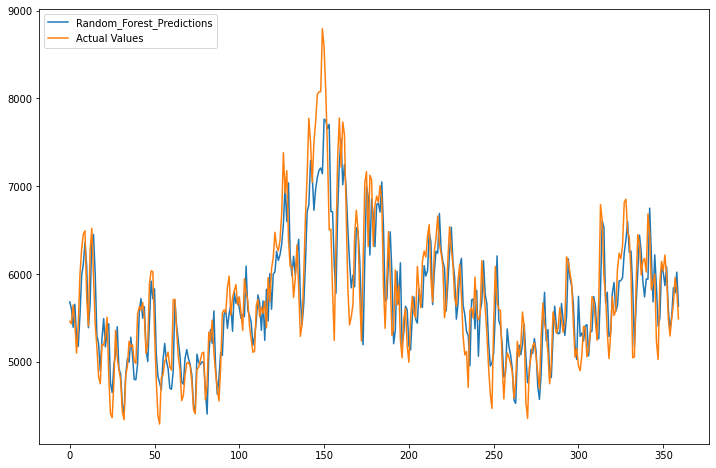

In [227]:
ran_pred=ran_model.predict(X_test)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(ran_pred,label='Random_Forest_Predictions')
plt.plot(y_test,label='Actual Values')
plt.legend(loc="upper left")
plt.show()

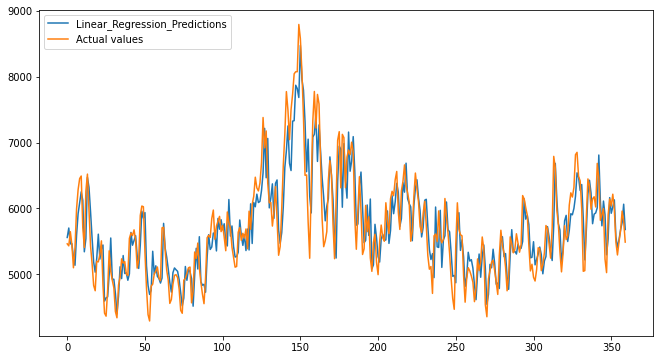

In [228]:
lin_pred=lin_model.predict(X_test)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11,6)
plt.plot(lin_pred,label='Linear_Regression_Predictions')
plt.plot(y_test,label='Actual values')
plt.legend(loc="upper left")
plt.show()

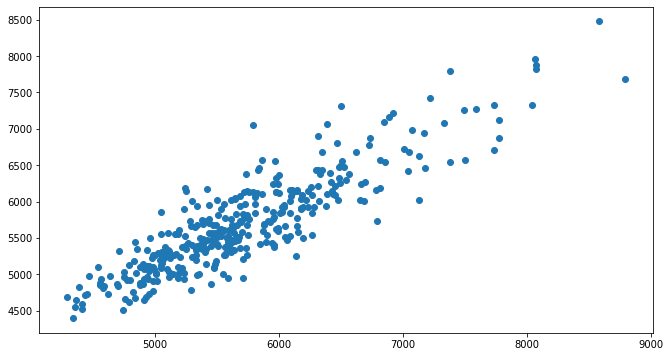

In [229]:
plt.scatter(y_test,lin_pred)

In [230]:
residual = y_test-lin_pred

c:\users\ankit\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

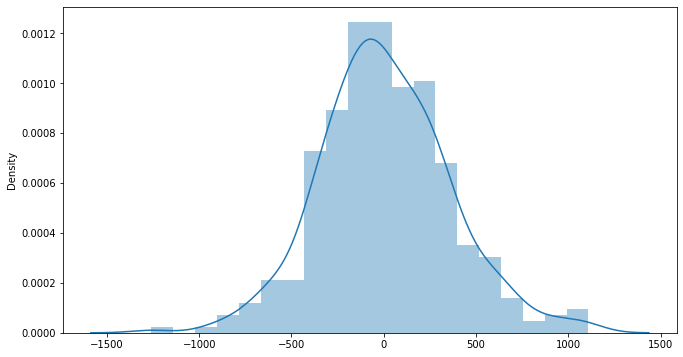

In [231]:
sns.distplot(residual)

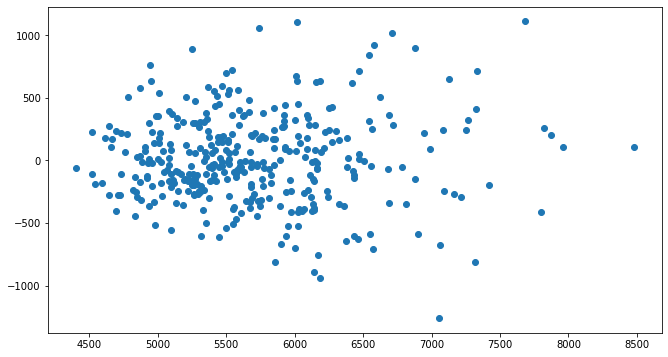

In [232]:
plt.scatter(lin_pred,residual)

In [233]:
from xgboost import XGBRegressor

In [234]:
xg_model = XGBRegressor()

In [235]:
xg_model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [236]:
predictions = xg_model.predict(X_test)

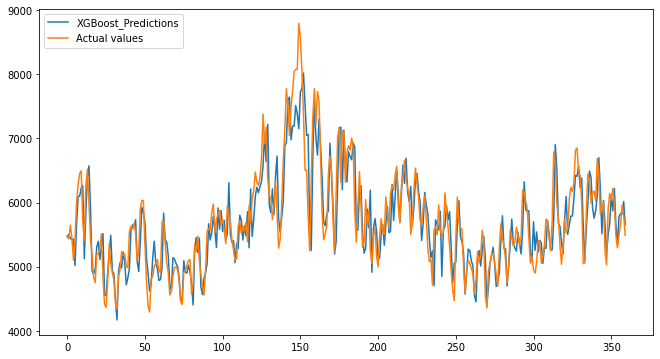

In [237]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11,6)
plt.plot(predictions,label='XGBoost_Predictions')
plt.plot(y_test,label='Actual values')
plt.legend(loc="upper left")
plt.show()

# Calculate the RMSE,MAPE and MAE

In [238]:
from sklearn.metrics import mean_squared_error, mean_absolute_error , mean_absolute_percentage_error
from math import sqrt

RMSE_RF=sqrt(mean_squared_error(ran_pred,y_test))
RMSE_LR=sqrt(mean_squared_error(lin_pred,y_test))
MAE_RF = mean_absolute_error(ran_pred,y_test)
MAE_LR = mean_absolute_error(lin_pred,y_test)
MAPE_RF = round((mean_absolute_percentage_error(ran_pred,y_test)*100),3)
MAPE_LR = round((mean_absolute_percentage_error(lin_pred,y_test)*100),3)
MAE_XG = mean_absolute_error(y_test, predictions)
MAPE_XG= round((mean_absolute_percentage_error(y_test,predictions)*100),3)
RMSE_xg=sqrt(mean_squared_error(predictions,y_test))

In [239]:
print('RMSE for Random Forest Model is:',RMSE_RF)
print('MAE for Random Forest Model is:',MAE_RF)
print('MAPE for Random Forest Model is:',MAPE_RF)


RMSE for Random Forest Model is: 368.6254439808971
MAE for Random Forest Model is: 282.91269212962953
MAPE for Random Forest Model is: 4.878


In [240]:
print('RMSE for Linear Regression Model is:',RMSE_LR)
print('MAE for Linear Regression Model is:',MAE_LR)
print('MAPE for Linear Regression Model is:',MAPE_LR)

RMSE for Linear Regression Model is: 354.20301093846933
MAE for Linear Regression Model is: 274.29793198712133
MAPE for Linear Regression Model is: 4.766


In [241]:
print('RMSE for XG Boost Model is:',RMSE_xg)
print('MAE for XG Boos Model is:',MAE_XG)
print('MAPE for XG Boos Model is:',MAPE_XG)

RMSE for XG Boost Model is: 369.54075945630785
MAE for XG Boos Model is: 279.7743078161169
MAPE for XG Boos Model is: 4.787


## Calculate forecasting accuracy

### 1.LR Model

In [242]:
from sklearn.linear_model import LinearRegression
final_lin_model=LinearRegression()

final_lin_model.fit(final_x,y)

LinearRegression()

In [243]:
forecast_check_data = np.array(daily_data['Energy'][:'2018-07-04'][-7:])

In [244]:
z=forecast_check_data

for i in range(0,30):
    ck=z[-7:]
    ck=np.array([ck])
    lin_f_chk=final_lin_model.predict(ck)
    z=np.append(z,lin_f_chk)
    i=+1
future_pred_lr=z[-30:]

In [245]:
future_pred_lr

array([6087.30698243, 6215.23781337, 6141.78872178, 6140.95503201,
       6521.64884611, 6673.32885511, 6625.74301689, 6130.42261224,
       6230.89683313, 6129.21093749, 6053.91198391, 6328.97324473,
       6399.52865133, 6699.48816079, 6124.48191418, 6286.60218596,
       6113.94523744, 6007.62762667, 6269.99807754, 6067.27074396,
       6762.77167276, 6016.78716747, 6389.24537908, 6086.94168664,
       5946.96763053, 6367.37971162, 5662.41127027, 6912.44076143,
       5748.63500007, 6559.26714784])

In [246]:
future_chk = pd.date_range('2018-07-05','2018-08-03', freq='D')
future_chk_df = pd.DataFrame(index=future_chk)

In [247]:
future_chk_df['future_chk_energy'] = future_pred_lr.tolist()

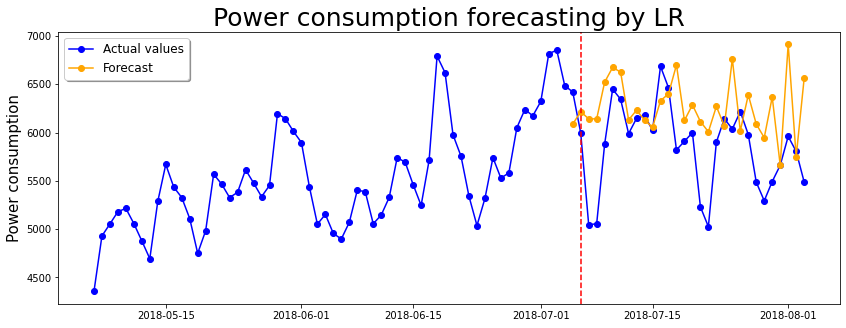

In [248]:
plt.figure(figsize=(14,5))
plt.title("Power consumption forecasting by LR", fontsize=25)

plt.plot(daily_data1[-90:].index,daily_data1[-90:].values, label='Actual values', color="blue", marker="o")

plt.plot(future_chk_df.index,future_chk_df.values, label='Forecast', color="orange", marker="o")
# plt.fill_between(future_df.index, lower_limits_f, upper_limits_f, alpha=0.1, color="orange")

plt.axvline(future_chk_df.index[1], color="red", linestyle="--")
plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Power consumption', fontsize=15)
plt.show()

In [249]:
daily_data_last_30 = daily_data['Energy'].tail(30)

In [250]:
MAE_check = mean_absolute_error(daily_data_last_30, future_chk_df)
MAPE_check= round((mean_absolute_percentage_error(daily_data_last_30,future_chk_df)*100),3)
RMSE_check=sqrt(mean_squared_error(future_chk_df,daily_data_last_30))


In [251]:
print('RMSE for forecast check is:',RMSE_check)
print('MAE for forecast check is:',MAE_check)
print('MAPE for forecast check is:',MAPE_check)

RMSE for forecast check is: 588.0840935079648
MAE for forecast check is: 461.52770388316225
MAPE for forecast check is: 8.25


### 2.RF Model

In [252]:
from sklearn.ensemble import RandomForestRegressor
final_RF_model=RandomForestRegressor(n_estimators=100,max_features=3, random_state=1)

In [253]:
final_RF_model.fit(final_x,y)

C:\Users\ankit\AppData\Local\Temp\ipykernel_12100\840889585.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  final_RF_model.fit(final_x,y)


RandomForestRegressor(max_features=3, random_state=1)

In [254]:
z=forecast_check_data

for i in range(0,30):
    ck=z[-7:]
    ck=np.array([ck])
    rf_f_chk=final_RF_model.predict(ck)
    z=np.append(z,rf_f_chk)
    i=+1
future_pred_RF=z[-30:]

In [255]:
future_pred_RF

array([5945.86958333, 6136.90791667, 6086.25333333, 6250.69875   ,
       6542.485     , 6758.99041667, 6531.91916667, 6015.34875   ,
       6178.44      , 5976.70208333, 6026.3625    , 6215.68708333,
       6644.21958333, 6579.14      , 6010.69583333, 6215.77083333,
       5829.03708333, 6125.25166667, 6027.42291667, 6548.03333333,
       6649.66333333, 5995.36916667, 6273.10416667, 5662.76125   ,
       6030.83583333, 5679.283125  , 6287.03708333, 6659.6975    ,
       5902.66583333, 6360.73791667])

In [256]:
future_chk_rf = pd.date_range('2018-07-05','2018-08-03', freq='D')
future_chk_df_rf = pd.DataFrame(index=future_chk_rf)
future_chk_df_rf['future_chk_energy'] = future_pred_RF.tolist()

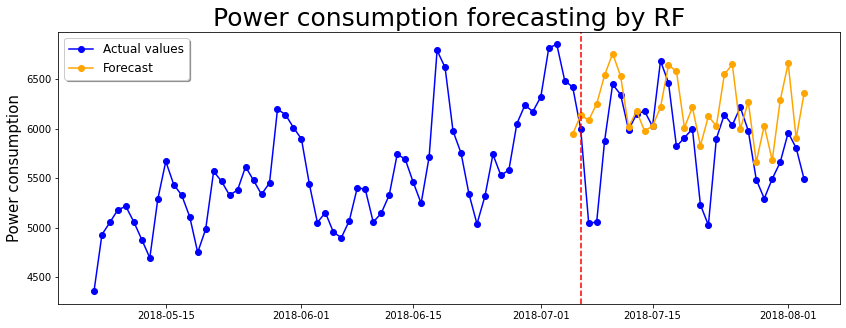

In [257]:
plt.figure(figsize=(14,5))
plt.title("Power consumption forecasting by RF", fontsize=25)

plt.plot(daily_data1[-90:].index,daily_data1[-90:].values, label='Actual values', color="blue", marker="o")

plt.plot(future_chk_df_rf.index,future_chk_df_rf.values, label='Forecast', color="orange", marker="o")
# plt.fill_between(future_df.index, lower_limits_f, upper_limits_f, alpha=0.1, color="orange")

plt.axvline(future_chk_df_rf.index[1], color="red", linestyle="--")
plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Power consumption', fontsize=15)
plt.show()

In [258]:
MAE_rf_check = mean_absolute_error(daily_data_last_30, future_chk_df_rf)
MAPE_rf_check= round((mean_absolute_percentage_error(daily_data_last_30,future_chk_df_rf)*100),3)
RMSE_rf_check=sqrt(mean_squared_error(future_chk_df_rf,daily_data_last_30))
print('RMSE for RF forecast check is:',RMSE_rf_check)
print('MAE for RF forecast check is:',MAE_rf_check)
print('MAPE for RF forecast check is:',MAPE_rf_check)

RMSE for RF forecast check is: 540.8064258418925
MAE for RF forecast check is: 425.20867361111124
MAPE for RF forecast check is: 7.571


### 3.XGB Model

In [259]:
from xgboost import XGBRegressor
final_xg_model = XGBRegressor()
final_xg_model.fit(final_x,y, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [260]:
z=forecast_check_data

for i in range(0,30):
    ck=z[-7:]
    ck=np.array([ck])
    xgb_f_chk=final_xg_model.predict(ck)
    z=np.append(z,xgb_f_chk)
    i=+1
future_pred_XGB=z[-30:]

In [261]:
future_pred_XGB

array([6386.38134766, 5998.98193359, 6202.90625   , 6141.52001953,
       6479.97265625, 6746.92773438, 6316.5234375 , 6392.40673828,
       5769.86962891, 6268.84423828, 5936.80957031, 6349.69824219,
       6694.56835938, 6280.96337891, 6523.03271484, 5496.15039062,
       6297.69677734, 5706.46826172, 6095.37402344, 6397.61474609,
       6126.63671875, 6811.75878906, 5240.66943359, 6527.95703125,
       5231.71679688, 5766.87939453, 6134.2109375 , 6131.51074219,
       7044.73974609, 5238.34423828])

In [262]:
future_chk_xgb = pd.date_range('2018-07-05','2018-08-03', freq='D')
future_chk_df_xgb = pd.DataFrame(index=future_chk_xgb)
future_chk_df_xgb['future_chk_energy'] = future_pred_XGB.tolist()

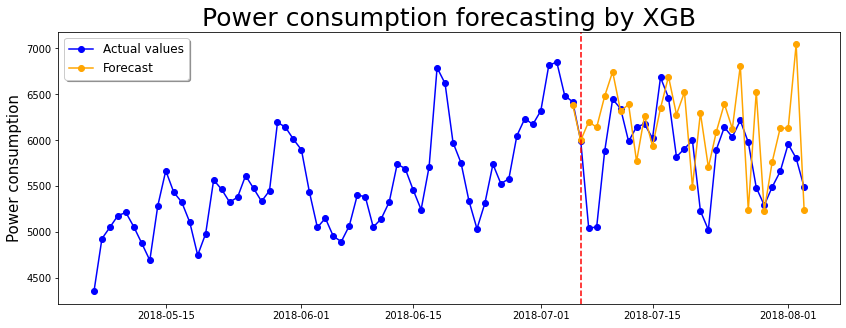

In [263]:
plt.figure(figsize=(14,5))
plt.title("Power consumption forecasting by XGB", fontsize=25)

plt.plot(daily_data1[-90:].index,daily_data1[-90:].values, label='Actual values', color="blue", marker="o")

plt.plot(future_chk_df_xgb.index,future_chk_df_xgb.values, label='Forecast', color="orange", marker="o")
# plt.fill_between(future_df.index, lower_limits_f, upper_limits_f, alpha=0.1, color="orange")

plt.axvline(future_chk_df_xgb.index[1], color="red", linestyle="--")
plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Power consumption', fontsize=15)
plt.show()

In [264]:
MAE_xgb_check = mean_absolute_error(daily_data_last_30, future_chk_df_xgb)
MAPE_xgb_check= round((mean_absolute_percentage_error(daily_data_last_30,future_chk_df_xgb)*100),3)
RMSE_xgb_check=sqrt(mean_squared_error(future_chk_df_xgb,daily_data_last_30))
print('RMSE for XGB forecast check is:',RMSE_xgb_check)
print('MAE for XGB forecast check is:',MAE_xgb_check)
print('MAPE for XGB forecast check is:',MAPE_xgb_check)

RMSE for XGB forecast check is: 575.2787936936085
MAE for XGB forecast check is: 448.09221462673605
MAPE for XGB forecast check is: 7.949


## Forecast

In [265]:
from sklearn.ensemble import RandomForestRegressor
final_RF_model=RandomForestRegressor(n_estimators=100,max_features=3, random_state=1)

In [266]:
final_RF_model.fit(final_x,y)

C:\Users\ankit\AppData\Local\Temp\ipykernel_12100\840889585.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  final_RF_model.fit(final_x,y)


RandomForestRegressor(max_features=3, random_state=1)

In [267]:
daily_data_last_7 = np.array(daily_data['Energy'].tail(7))
daily_data_last_7

array([5485.79166667, 5293.83333333, 5492.70833333, 5660.75      ,
       5959.70833333, 5805.04166667, 5489.        ])

In [268]:
np.savetxt("daily_data_last_7.csv", daily_data_last_7, delimiter=",")

In [269]:
z=daily_data_last_7

for i in range(0,30):
    r=z[-7:]
    r=np.array([r])
    ranf_f=final_RF_model.predict(r)
    z=np.append(z,ranf_f)
    i=+1
future_pred=z[-30:]

In [270]:
future_pred

array([5777.20395833, 5249.90708333, 5517.54375   , 5509.47041667,
       5920.86541667, 5818.44416667, 5537.19208333, 6009.57666667,
       5260.88875   , 5837.40833333, 5370.94083333, 5786.88416667,
       5780.18416667, 5486.65833333, 5994.43625   , 5244.35541667,
       5907.54208333, 5334.28020833, 5746.03854167, 5851.41458333,
       5496.80583333, 5997.78166667, 5215.05708333, 5911.1475    ,
       5261.133125  , 5597.98104167, 5800.98      , 5515.10791667,
       6022.59125   , 5167.75333333])

In [271]:
future = pd.date_range('2018-08-04','2018-09-02', freq='D')
future_df = pd.DataFrame(index=future)

In [272]:
future_df['future_energy'] = future_pred.tolist()

In [273]:
print(future_df)

            future_energy
2018-08-04    5777.203958
2018-08-05    5249.907083
2018-08-06    5517.543750
2018-08-07    5509.470417
2018-08-08    5920.865417
2018-08-09    5818.444167
2018-08-10    5537.192083
2018-08-11    6009.576667
2018-08-12    5260.888750
2018-08-13    5837.408333
2018-08-14    5370.940833
2018-08-15    5786.884167
2018-08-16    5780.184167
2018-08-17    5486.658333
2018-08-18    5994.436250
2018-08-19    5244.355417
2018-08-20    5907.542083
2018-08-21    5334.280208
2018-08-22    5746.038542
2018-08-23    5851.414583
2018-08-24    5496.805833
2018-08-25    5997.781667
2018-08-26    5215.057083
2018-08-27    5911.147500
2018-08-28    5261.133125
2018-08-29    5597.981042
2018-08-30    5800.980000
2018-08-31    5515.107917
2018-09-01    6022.591250
2018-09-02    5167.753333


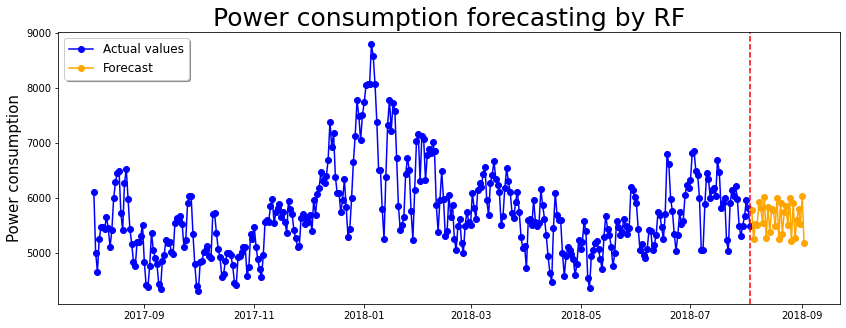

In [274]:
plt.figure(figsize=(14,5))
plt.title("Power consumption forecasting by RF", fontsize=25)

plt.plot(daily_data1[-365:].index,daily_data1[-365:].values, label='Actual values', color="blue", marker="o")

plt.plot(future_df.index,future_df.values, label='Forecast', color="orange", marker="o")
# plt.fill_between(future_df.index, lower_limits_f, upper_limits_f, alpha=0.1, color="orange")

plt.axvline(daily_data1.index[-1], color="red", linestyle="--")
plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Power consumption', fontsize=15)
plt.show()

## Saving the model

In [275]:
!pip install pickle-mixin

You should consider upgrading via the 'c:\users\ankit\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [276]:
import pickle

In [277]:
filename = 'final_rf_model.pkl'
pickle.dump(final_RF_model, open(filename,'wb'))

In [278]:
pickled_model=pickle.load(open('final_rf_model.pkl','rb'))

In [279]:
pk=pickled_model.predict(X_test)